In [1]:
#Importamos las librerias necesarias 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error
!pip install pmdarima
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate=False
logger.setLevel(logging.CRITICAL)

In [2]:
productos = pd.read_csv(r"C:\Users\adrik\Downloads\product_actualizado.csv")
ventas = pd.read_csv(r"C:\Users\adrik\Downloads\ventas_total.csv")
clima = pd.read_csv(r"C:\Users\adrik\Downloads\clima.csv")
feriados = pd.read_csv(r"C:\Users\adrik\Downloads\feriados.csv")

In [3]:
clima

fecha  temperatura_media  precipitacion
0     2021-01-02               20.2            0.0
1     2021-01-03               21.8            0.0
2     2021-01-05               19.2            0.0
3     2021-01-07               21.2            0.0
4     2021-01-08               20.7            0.0
...          ...                ...            ...
1132  2022-10-20                NaN            0.0
1133  2022-10-21                NaN            0.0
1134  2022-10-22                NaN            0.0
1135  2022-10-23                NaN            0.0
1136  2022-10-24                NaN            0.0

[1137 rows x 3 columns]

In [4]:
feriados

Fecha                                            Feriado
0   01/01/2024      Año Nuevo (irrenunciable de quinta categoría)
1   29/03/2024                  Viernes Santo (feriado religioso)
2   30/03/2024                   Sábado Santo (feriado religioso)
3   01/05/2024  Día Nacional del Trabajo (irrenunciable de qui...
4   21/05/2024                         Día de las Glorias Navales
..         ...                                                ...
63  31/10/2022  Día Nacional de las Iglesias Evangélicas y Pro...
64  01/11/2022        Día de Todos los Santos (feriado religioso)
65  08/12/2022  Inmaculada Concepción de la Virgen (feriado re...
66  25/12/2022  Natividad del Señor (feriado religioso) (irren...
67  31/12/2022                     feriado bancario de fin de año

[68 rows x 2 columns]

In [5]:
nuevas_fechas = [
    {"Fecha": "14/02/2022", "Feriado": "Día de San Valentín"},
    {"Fecha": "14/02/2023", "Feriado": "Día de San Valentín"}
]

# Convertir las nuevas fechas en un DataFrame y luego concatenarlo con el original
df_nuevas_fechas = pd.DataFrame(nuevas_fechas)
feriados = pd.concat([feriados, df_nuevas_fechas], ignore_index=True)

In [6]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53604 entries, 0 to 53603
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           53604 non-null  int64  
 1   total        53604 non-null  float64
 2   gratuity     53604 non-null  float64
 3   discounts    53604 non-null  float64
 4   taxes        53604 non-null  float64
 5   subtotal     53604 non-null  float64
 6   payed        53604 non-null  float64
 7   table_id     53604 non-null  object 
 8   waiter_id    53604 non-null  int64  
 9   date_open    53604 non-null  object 
 10  date_closed  53604 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [7]:
ventas.duplicated(subset=['id']).sum()

224

In [8]:
ventas.drop_duplicates(subset=['id'], inplace=True)

In [9]:
productos

order_id product_id  quantity    payed   taxes  discounts  \
0       4503601585848320       6650         1   4490.0   717.0        0.0   
1       4503645076586496       6870         1   3890.0   621.0        0.0   
2       4503645076586496       2650         1   4190.0   669.0        0.0   
3       4503645076586496       6870         1   3890.0   621.0        0.0   
4       4503645076586496       6590         1   6990.0  1116.0        0.0   
...                  ...        ...       ...      ...     ...        ...   
172793  6755396743200768       4351         1  12990.0  2074.0        0.0   
172794  6755396743200768       4680         1   4790.0   765.0        0.0   
172795  6755396743200768       4680         1   4790.0   765.0        0.0   
172796  6755396743200768       1390         1   2390.0   382.0        0.0   
172797  6755397736857600       1690         1   7490.0  1196.0        0.0   

                           producto  net_price hierarchy_id hierarchy  
0                        Mistral 35     4490.0       AB.075       Bar  
1                 Jugo de frambuesa     1422.0       AB.075       Bar  
2                    Schop heineken     2990.0       AB.085    Schops  
3                 Jugo de frambuesa     1422.0       AB.075       Bar  
4       Jhonnie Walker Black Label      6990.0       AB.075       Bar  
...                             ...        ...          ...       ...  
172793   choclo champiñon compartir        0.0       AB.530   PAPITAS  
172794                     Absolute     4990.0       AB.075       Bar  
172795                     Absolute     4990.0       AB.075       Bar  
172796                        fanta      990.0       AB.050  Drinks 🥤  
172797       Hamburguesa  Americana     6290.0       AB.020   Burgers  

[172798 rows x 10 columns]

In [10]:
df = pd.merge(productos, ventas[['id', 'date_open']], left_on='order_id', right_on='id', how='left')
df.drop('id', axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172798 entries, 0 to 172797
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      172798 non-null  int64  
 1   product_id    172798 non-null  object 
 2   quantity      172798 non-null  int64  
 3   payed         172798 non-null  float64
 4   taxes         172798 non-null  float64
 5   discounts     172798 non-null  float64
 6   producto      172798 non-null  object 
 7   net_price     172798 non-null  float64
 8   hierarchy_id  172798 non-null  object 
 9   hierarchy     172798 non-null  object 
 10  date_open     172798 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 15.8+ MB


In [12]:
# Convertir las columnas de fecha a datetime
df['date_open'] = pd.to_datetime(df['date_open'], format='%Y-%m-%dT%H:%M:%S').dt.date
clima['fecha'] = pd.to_datetime(clima['fecha'], format='%Y/%m/%d').dt.date
feriados['Fecha'] = pd.to_datetime(feriados['Fecha'], format='%d/%m/%Y').dt.date

# Unir el dataframe de ventas con el dataframe de clima
df = pd.merge(df, clima, left_on='date_open', right_on='fecha', how='left')

# Unir el resultado anterior con el dataframe de feriados
df = pd.merge(df, feriados, left_on='date_open', right_on='Fecha', how='left')

# Seleccionando columnas relevantes y eliminando duplicados de fecha después del merge
df = df.drop(columns=['fecha', 'Fecha'])

df

order_id product_id  quantity    payed   taxes  discounts  \
0       4503601585848320       6650         1   4490.0   717.0        0.0   
1       4503645076586496       6870         1   3890.0   621.0        0.0   
2       4503645076586496       2650         1   4190.0   669.0        0.0   
3       4503645076586496       6870         1   3890.0   621.0        0.0   
4       4503645076586496       6590         1   6990.0  1116.0        0.0   
...                  ...        ...       ...      ...     ...        ...   
172793  6755396743200768       4351         1  12990.0  2074.0        0.0   
172794  6755396743200768       4680         1   4790.0   765.0        0.0   
172795  6755396743200768       4680         1   4790.0   765.0        0.0   
172796  6755396743200768       1390         1   2390.0   382.0        0.0   
172797  6755397736857600       1690         1   7490.0  1196.0        0.0   

                           producto  net_price hierarchy_id hierarchy  \
0                        Mistral 35     4490.0       AB.075       Bar   
1                 Jugo de frambuesa     1422.0       AB.075       Bar   
2                    Schop heineken     2990.0       AB.085    Schops   
3                 Jugo de frambuesa     1422.0       AB.075       Bar   
4       Jhonnie Walker Black Label      6990.0       AB.075       Bar   
...                             ...        ...          ...       ...   
172793   choclo champiñon compartir        0.0       AB.530   PAPITAS   
172794                     Absolute     4990.0       AB.075       Bar   
172795                     Absolute     4990.0       AB.075       Bar   
172796                        fanta      990.0       AB.050  Drinks 🥤   
172797       Hamburguesa  Americana     6290.0       AB.020   Burgers   

         date_open  temperatura_media  precipitacion Feriado  
0       2023-01-24               22.6            0.0     NaN  
1       2023-03-17               21.0            0.0     NaN  
2       2023-03-17               21.0            0.0     NaN  
3       2023-03-17               21.0            0.0     NaN  
4       2023-03-17               21.0            0.0     NaN  
...            ...                ...            ...     ...  
172793  2024-01-11               22.3            0.0     NaN  
172794  2024-01-11               22.3            0.0     NaN  
172795  2024-01-11               22.3            0.0     NaN  
172796  2024-01-11               22.3            0.0     NaN  
172797  2022-01-04               22.1            0.0     NaN  

[172798 rows x 14 columns]

In [13]:
df['producto'] = df['producto'].str.replace(r'\s+', ' ', regex=True)
df['producto'] = df['producto'].str.replace(r'\s+', ' ', regex=True).str.strip()
df = df[df['producto'] != 'Aparte']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171560 entries, 0 to 172797
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           171560 non-null  int64  
 1   product_id         171560 non-null  object 
 2   quantity           171560 non-null  int64  
 3   payed              171560 non-null  float64
 4   taxes              171560 non-null  float64
 5   discounts          171560 non-null  float64
 6   producto           171560 non-null  object 
 7   net_price          171560 non-null  float64
 8   hierarchy_id       171560 non-null  object 
 9   hierarchy          171560 non-null  object 
 10  date_open          171560 non-null  object 
 11  temperatura_media  163310 non-null  float64
 12  precipitacion      171560 non-null  float64
 13  Feriado            9179 non-null    object 
dtypes: float64(6), int64(2), object(6)
memory usage: 19.6+ MB


In [15]:
# Convertir 'precipitacion' a binario: 1 si llovió, 0 si no
df['precipitacion'] = (df['precipitacion'] > 0).astype(int)
# Convertir 'Feriado' a binario: 1 si es feriado, 0 si no
# Asumimos que NaN significa que no es feriado, por lo tanto reemplazamos NaN por 0
# y cualquier otro valor por 1.
df['Feriado'] = df['Feriado'].notna().astype(int)
df.info()

C:\Users\adrik\AppData\Local\Temp\ipykernel_300\3013674155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['precipitacion'] = (df['precipitacion'] > 0).astype(int)
C:\Users\adrik\AppData\Local\Temp\ipykernel_300\3013674155.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Feriado'] = df['Feriado'].notna().astype(int)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 171560 entries, 0 to 172797
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           171560 non-null  int64  
 1   product_id         171560 non-null  object 
 2   quantity           171560 non-null  int64  
 3   payed              171560 non-null  float64
 4   taxes              171560 non-null  float64
 5   discounts          171560 non-null  float64
 6   producto           171560 non-null  object 
 7   net_price          171560 non-null  float64
 8   hierarchy_id       171560 non-null  object 
 9   hierarchy          171560 non-null  object 
 10  date_open          171560 non-null  object 
 11  temperatura_media  163310 non-null  float64
 12  precipitacion      171560 non-null  int32  
 13  Feriado            171560 non-null  int32  
dtypes: float64(5), int32(2), int64(2), object(5)
memory usage: 18.3+ MB


In [16]:
df = df[['producto', 'date_open', 'Feriado']]
df = df.rename(columns={
    'date_open': 'fecha',
    'Feriado': 'feriado'
})
df = df.sort_values(by='fecha', ascending=True)
df

producto       fecha  feriado
160012                         Costo Delivery  2021-08-13        0
141011                       veggie compartir  2021-08-13        0
56974    2 hamburguesas con papas + 2 bebidas  2021-08-13        0
56975   Hamburguesa Americana con papas promo  2021-08-13        0
56976         Hamburguesa Hot con papas promo  2021-08-13        0
...                                       ...         ...      ...
77293                               Caipiriña  2024-02-11        0
77292                            Tropical gin  2024-02-11        0
49804                   Hamburguesa Americana  2024-02-11        0
49806                   Hamburguesa Americana  2024-02-11        0
171685                 beefie compartir promo  2024-02-11        0

[171560 rows x 3 columns]

In [17]:
df['fecha'] = pd.to_datetime(df['fecha'])
# Establecer la columna 'fecha' como el índice del DataFrame
df.set_index('fecha', inplace=True)
# Agrupar los datos por producto y semana, y contar las ventas para cada grupo
ventas_semanales = df.groupby(['producto', pd.Grouper(freq='W')]).size().reset_index(name='ventas_semanales')
# Ver las primeras filas del DataFrame resultante para verificar la agrupación y el conteo
ventas_semanales

producto      fecha  ventas_semanales
0              2 Black label 2023-01-22                 8
1                  2 Cacique 2023-02-19                 1
2                  2 Cacique 2023-03-05                 1
3                  2 Cacique 2023-08-06                 3
4      2 Cosmopolitan x 7990 2022-04-03                 4
...                      ...        ...               ...
17004      veggie individual 2024-01-14                 2
17005      veggie individual 2024-01-21                12
17006      veggie individual 2024-01-28                 7
17007      veggie individual 2024-02-04                 8
17008      veggie individual 2024-02-11                 6

[17009 rows x 3 columns]

In [18]:
# Identificar los productos que tienen al menos 104 registros semanales (2 años de datos semanales)
productos = ventas_semanales.groupby('producto').filter(lambda x: len(x) >= 104)['producto'].unique()
# Filtrar los datos para quedarnos solo con esos productos
df = ventas_semanales[ventas_semanales['producto'].isin(productos)]
df

producto      fecha  ventas_semanales
328     2 SCHOP HEINEKEN 2021-12-12                 2
329     2 SCHOP HEINEKEN 2021-12-19                24
330     2 SCHOP HEINEKEN 2021-12-26                 2
331     2 SCHOP HEINEKEN 2022-01-02                47
332     2 SCHOP HEINEKEN 2022-01-09                25
...                  ...        ...               ...
17004  veggie individual 2024-01-14                 2
17005  veggie individual 2024-01-21                12
17006  veggie individual 2024-01-28                 7
17007  veggie individual 2024-02-04                 8
17008  veggie individual 2024-02-11                 6

[9231 rows x 3 columns]

In [19]:
# Suponiendo que tu DataFrame se llama df
# Asegúrate de que tu DataFrame esté cargado correctamente aquí.
# Calcular el promedio de ventas semanales por producto
promedio_por_producto = df.groupby('producto')['ventas_semanales'].mean()
# Por ejemplo, establecer el umbral como el 25% percentil de los promedios de ventas
umbral = promedio_por_producto.quantile(0.5)
# Filtrar para obtener los productos con un promedio de ventas por debajo del umbral
productos_bajo_rendimiento = promedio_por_producto[promedio_por_producto < umbral].index.tolist()
# Mostrar los productos que se consideran de bajo rendimiento
productos_bajo_rendimiento

['Aperol Spritz',
 'Bacon',
 'Caipiriña',
 'Calypso',
 'Crema acida',
 'Guacamole',
 'Hamburguesa Americana con papas promo',
 'Hamburguesa Vegana',
 'Hamburguesa Vegetariana con papas promo',
 'Honey Mustard',
 'Jugo de frambuesa',
 'Jugo de mango',
 'Jugo de maracuya',
 'Lemon Garlic',
 'Limonada Menta Jengibre',
 'Limonada menta',
 'Margarita',
 'Moscow Mule',
 'Pebre',
 'Pisco Sour',
 'Salsa de la casa',
 'Salsa picante',
 'Tom Collins',
 'Vegetales salteados',
 'beefie compartir promo',
 'chicken curry compartir',
 'chicken curry individual',
 'choclo champiñon compartir promo',
 'fanta',
 'jugo durazno promo',
 'mechada compartir promo',
 'mexa individual',
 'pollo albahaca individual',
 'single fries individual',
 'sprite',
 'sprite promo',
 'veggie compartir promo',
 'veggie individual']

In [20]:
df= df[~df['producto'].isin(productos_bajo_rendimiento)]

In [21]:
df['producto'].nunique()

38

In [22]:
df.to_csv('var.csv', index=False)

In [23]:
# Palabras clave para identificar los productos de comida
palabras_clave_comida = ['papas', 'individual', 'compartir', 'Hamburguesa', 'Chicken', 'Cheddar', 'Crema acida', 'Salsa','Vegetales salteados']
# Crear la cadena de consulta para comida
consulta_comida = " | ".join([f"producto.str.contains('{palabra}', case=False, na=False)" for palabra in palabras_clave_comida])
# Filtrar el DataFrame para obtener solo los productos de comida
df_comida = df.query(consulta_comida)
# Filtrar el DataFrame para obtener los productos que no son comida (tragos)
df_tragos = df.query(f"not ({consulta_comida})")

In [24]:
# Asegúrate de que df_comida y df_tragos son copias independientes para evitar la advertencia
df_comida = df_comida.copy()
df_tragos = df_tragos.copy()

# Asignar valores a la nueva columna 'semana_del_año' correctamente
df_comida['semana_del_año'] = df['fecha'].dt.isocalendar().week
df_tragos['semana_del_año'] = df['fecha'].dt.isocalendar().week

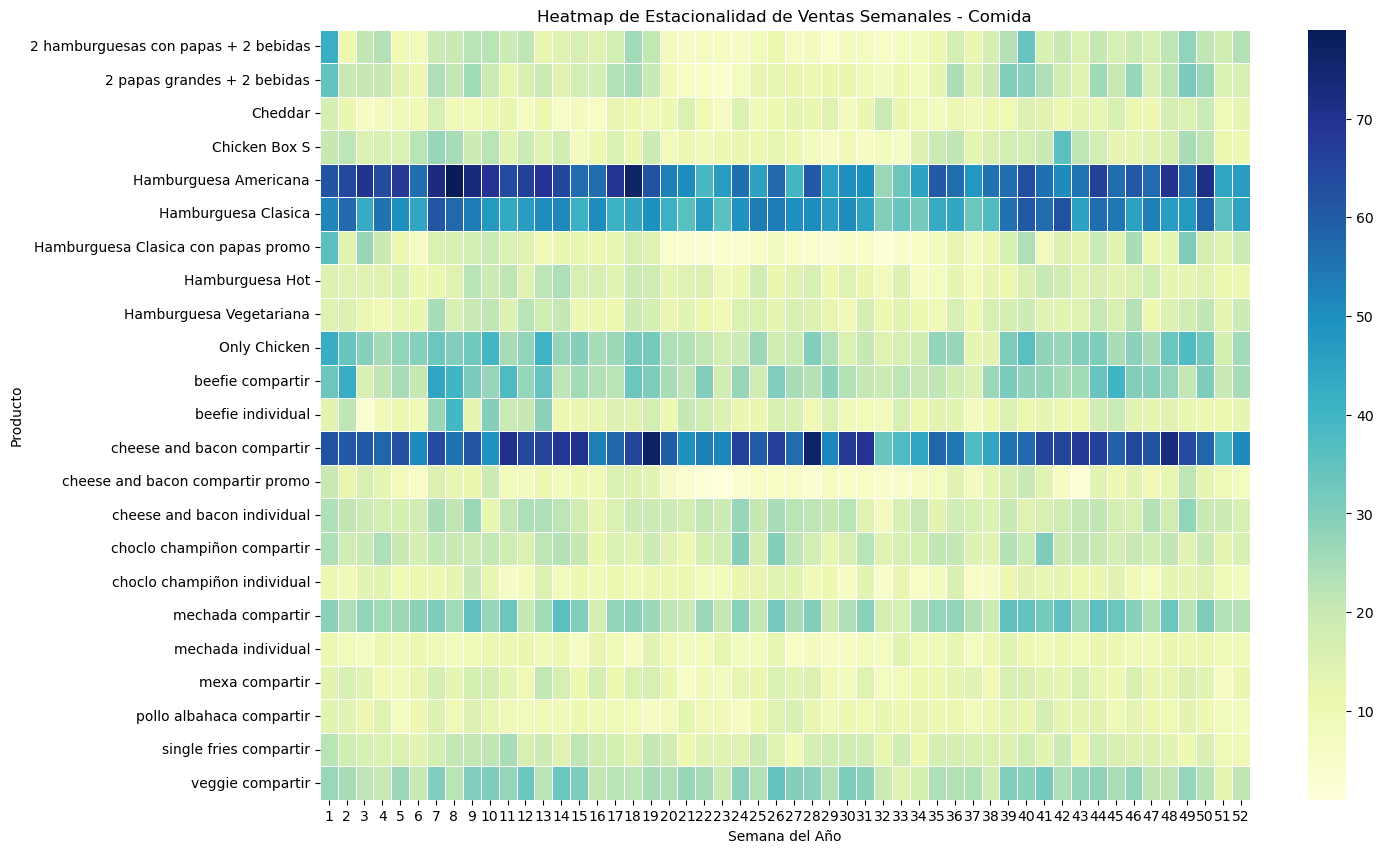

In [25]:
heatmap_data_comida = df_comida.groupby(['producto', 'semana_del_año']).ventas_semanales.mean().unstack()
# Crear el heatmap para comida
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_comida, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Semanales - Comida')
plt.ylabel('Producto')
plt.xlabel('Semana del Año')
plt.show()

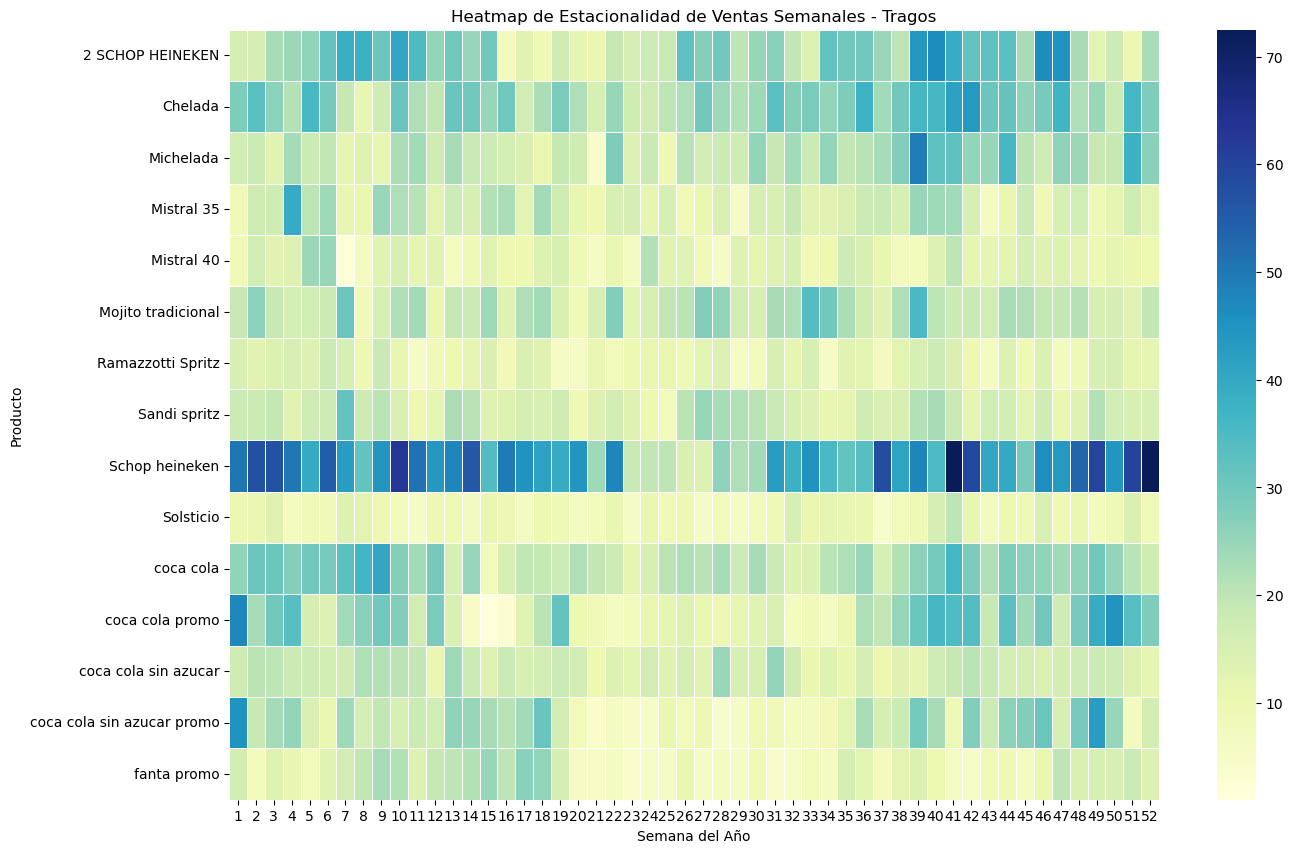

In [26]:
heatmap_data_tragos = df_tragos.groupby(['producto', 'semana_del_año']).ventas_semanales.mean().unstack()
# Crear el heatmap para tragos
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_tragos, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Semanales - Tragos')
plt.ylabel('Producto')
plt.xlabel('Semana del Año')
plt.show()

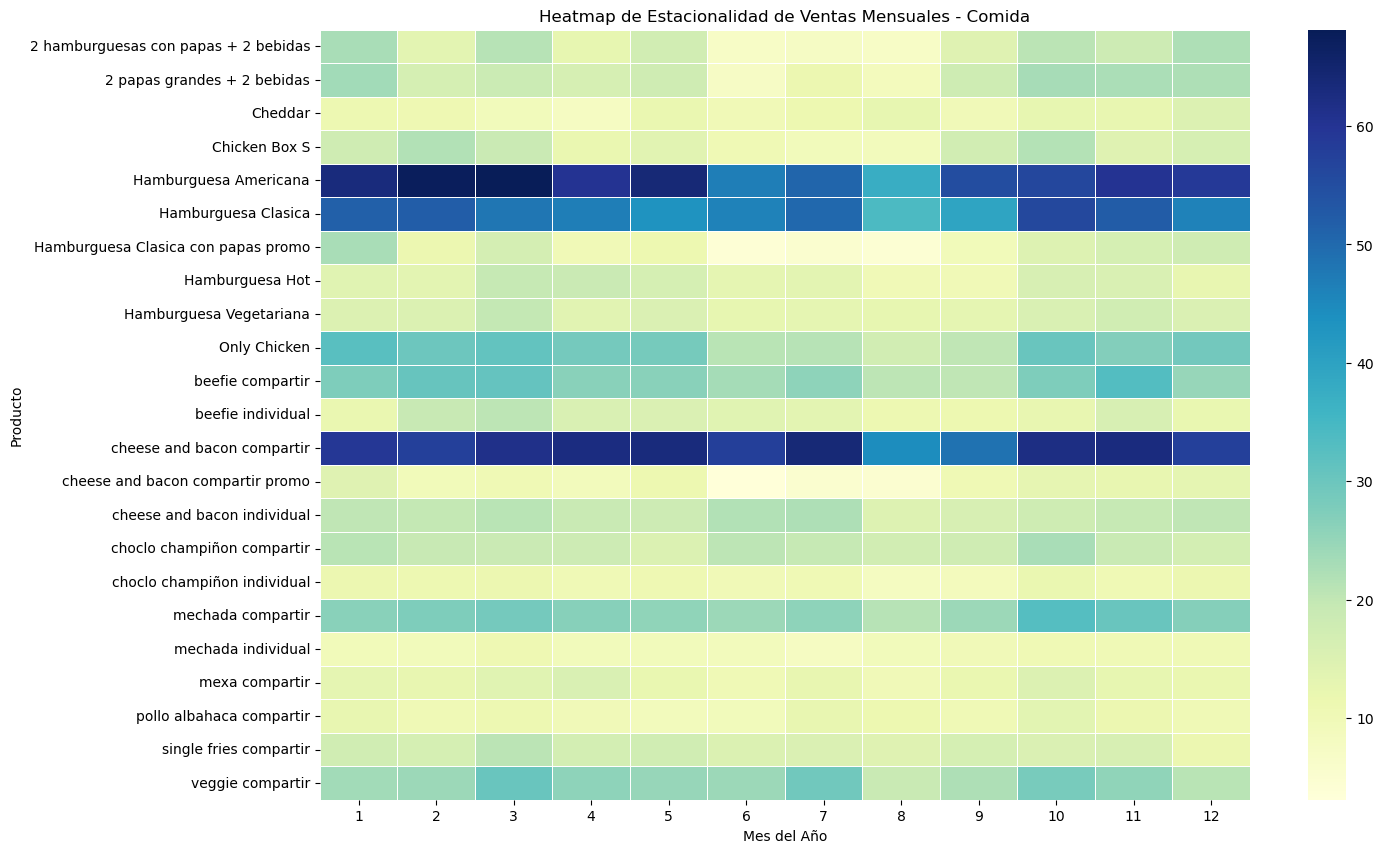

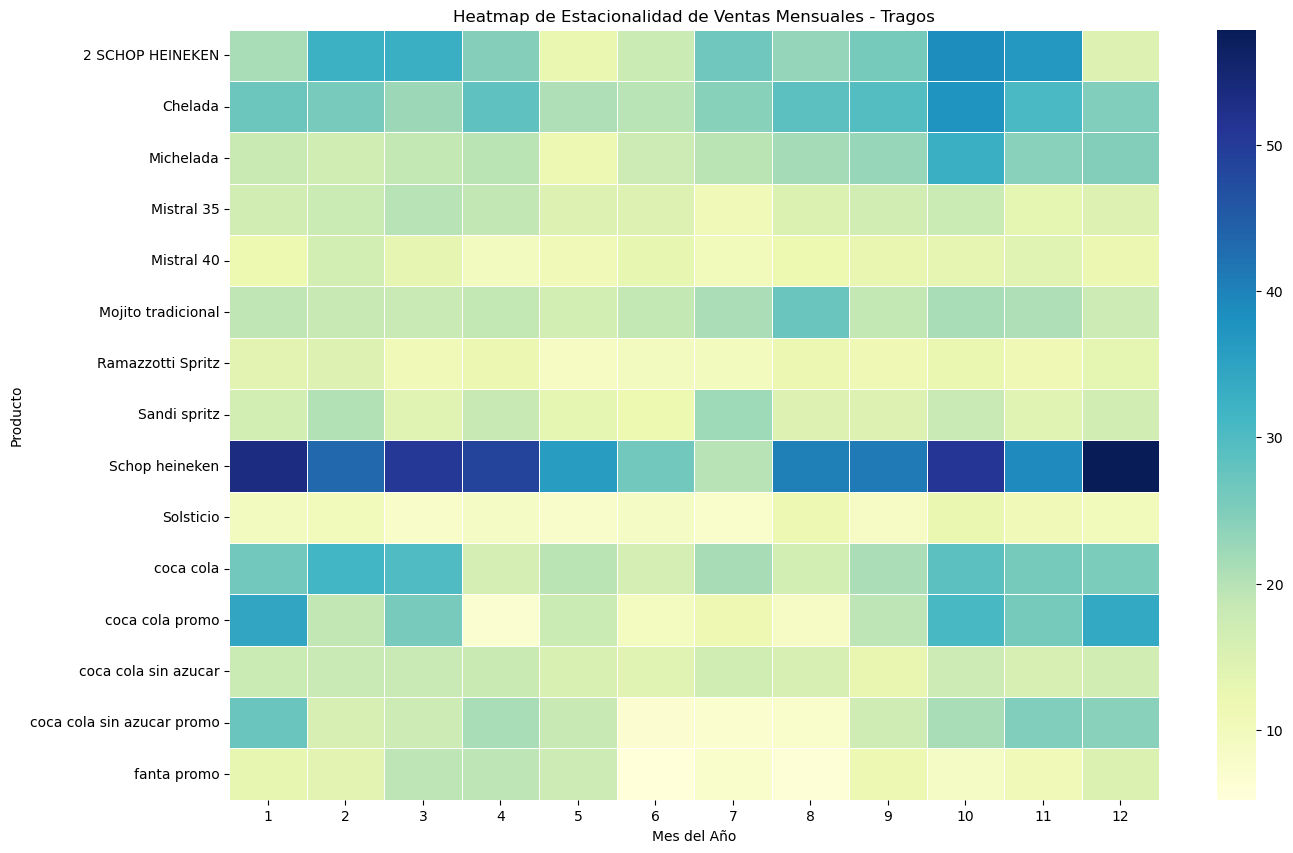

In [27]:
# Agregar la columna 'mes_del_año' a cada DataFrame
df_comida['mes_del_año'] = df_comida['fecha'].dt.month
df_tragos['mes_del_año'] = df_tragos['fecha'].dt.month
# Preparar los datos para los heatmaps mensuales
heatmap_data_comida_mensual = df_comida.groupby(['producto', 'mes_del_año']).ventas_semanales.mean().unstack()
heatmap_data_tragos_mensual = df_tragos.groupby(['producto', 'mes_del_año']).ventas_semanales.mean().unstack()

# Crear los heatmaps mensuales
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_comida_mensual, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Mensuales - Comida')
plt.ylabel('Producto')
plt.xlabel('Mes del Año')

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_tragos_mensual, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap de Estacionalidad de Ventas Mensuales - Tragos')
plt.ylabel('Producto')
plt.xlabel('Mes del Año')
plt.show()


In [28]:
df

producto      fecha  ventas_semanales
328    2 SCHOP HEINEKEN 2021-12-12                 2
329    2 SCHOP HEINEKEN 2021-12-19                24
330    2 SCHOP HEINEKEN 2021-12-26                 2
331    2 SCHOP HEINEKEN 2022-01-02                47
332    2 SCHOP HEINEKEN 2022-01-09                25
...                 ...        ...               ...
16754  veggie compartir 2024-01-14                22
16755  veggie compartir 2024-01-21                20
16756  veggie compartir 2024-01-28                13
16757  veggie compartir 2024-02-04                20
16758  veggie compartir 2024-02-11                16

[4785 rows x 3 columns]

In [29]:
# Establecer la columna 'fecha' como el índice del dataframe
df.set_index('fecha', inplace=True)

# Reorganizar el dataframe para tener las ventas semanales como columnas separadas
df_pivot = df.pivot_table(index='fecha', columns='producto', values='ventas_semanales', fill_value=0)
# Si hay fechas faltantes, puedes rellenarlas con 0
df_pivot = df_pivot.resample('W').sum().fillna(0)


# Ahora df_pivot está listo para ser utilizado en un modelo VAR
df_pivot.head()

producto    2 SCHOP HEINEKEN  2 hamburguesas con papas + 2 bebidas  \
fecha                                                                
2021-08-15                 0                                     4   
2021-08-22                 0                                     0   
2021-08-29                 0                                    11   
2021-09-05                 0                                    20   
2021-09-12                 0                                    34   

producto    2 papas grandes + 2 bebidas  Cheddar  Chelada  Chicken Box S  \
fecha                                                                      
2021-08-15                            3        0        0              1   
2021-08-22                            6        0        0              3   
2021-08-29                            7        4        0             23   
2021-09-05                           24       12        0             40   
2021-09-12                           49       18        0             48   

producto    Hamburguesa Americana  Hamburguesa Clasica  \
fecha                                                    
2021-08-15                      5                    5   
2021-08-22                      4                    2   
2021-08-29                     38                   23   
2021-09-05                     59                   26   
2021-09-12                     59                   50   

producto    Hamburguesa Clasica con papas promo  Hamburguesa Hot  ...  \
fecha                                                             ...   
2021-08-15                                    1                0  ...   
2021-08-22                                    0                0  ...   
2021-08-29                                    8                1  ...   
2021-09-05                                   15                6  ...   
2021-09-12                                   25               11  ...   

producto    coca cola promo  coca cola sin azucar  coca cola sin azucar promo  \
fecha                                                                           
2021-08-15                4                     0                           4   
2021-08-22                4                     3                           3   
2021-08-29                5                     5                           7   
2021-09-05               11                     9                          24   
2021-09-12               42                    21                          51   

producto    fanta promo  mechada compartir  mechada individual  \
fecha                                                            
2021-08-15            0                  2                   0   
2021-08-22            0                  5                   0   
2021-08-29            6                  5                   8   
2021-09-05           24                 10                  14   
2021-09-12           24                 19                  20   

producto    mexa compartir  pollo albahaca compartir  single fries compartir  \
fecha                                                                          
2021-08-15               2                         3                       0   
2021-08-22               2                         2                       0   
2021-08-29               4                         8                       8   
2021-09-05               3                         5                      14   
2021-09-12              13                        10                      17   

producto    veggie compartir  
fecha                         
2021-08-15                 4  
2021-08-22                 1  
2021-08-29                11  
2021-09-05                24  
2021-09-12                27  

[5 rows x 38 columns]

RMSE para 2 SCHOP HEINEKEN: 10.8916220591272


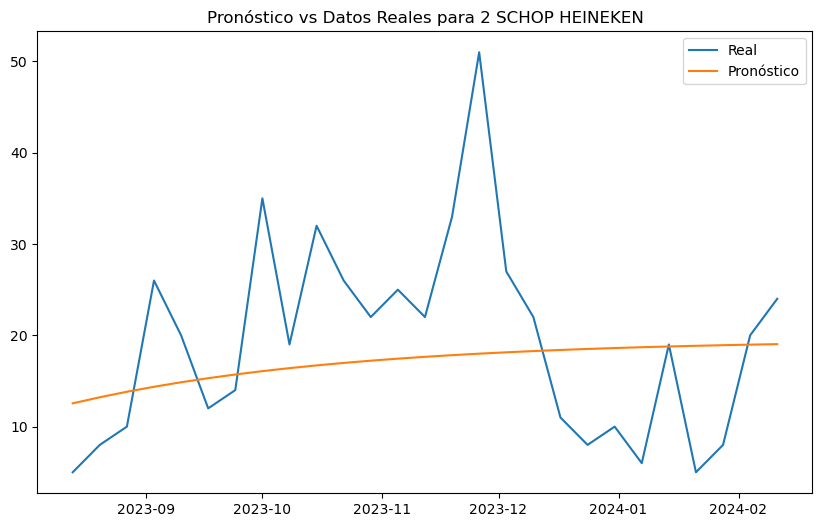

RMSE para 2 hamburguesas con papas + 2 bebidas: 1.5594131799485946


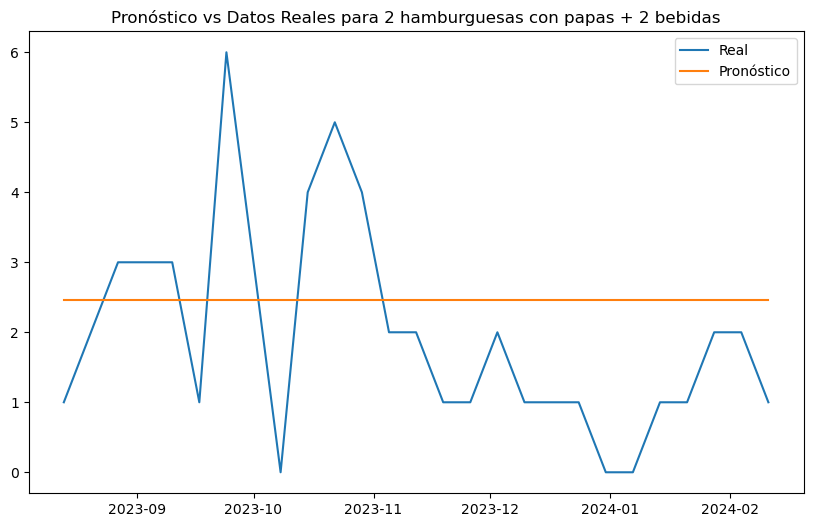

RMSE para 2 papas grandes + 2 bebidas: 3.2193635528041415


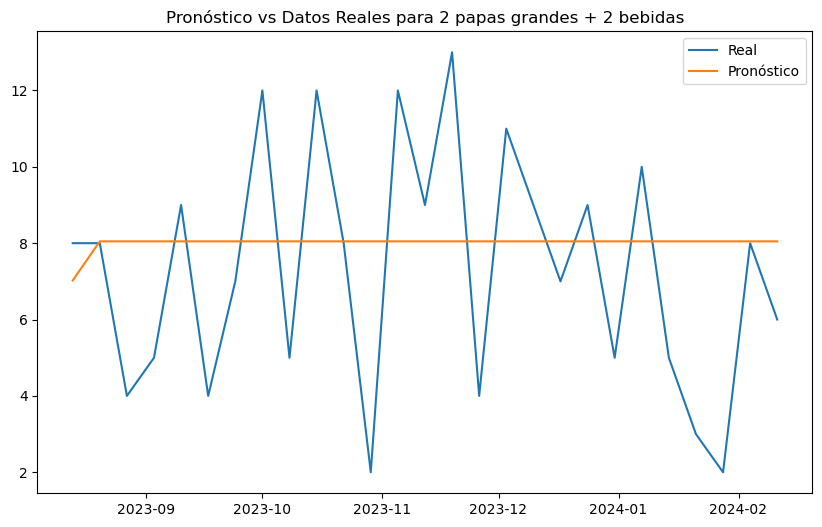

RMSE para Cheddar: 3.95497583080885


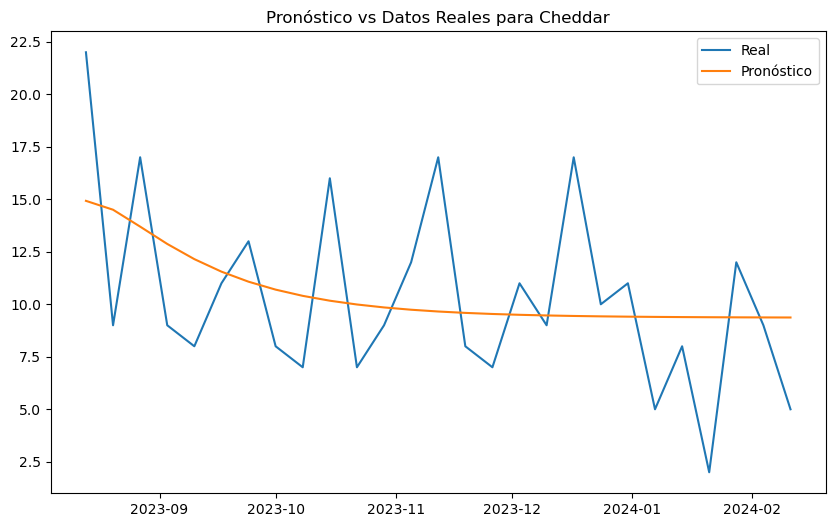

RMSE para Chelada: 6.734981365425862


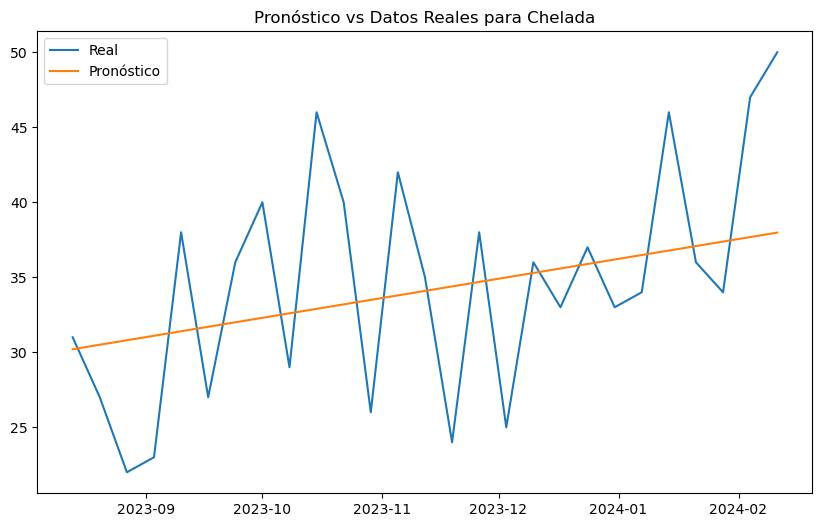

RMSE para Chicken Box S: 2.934716162062134


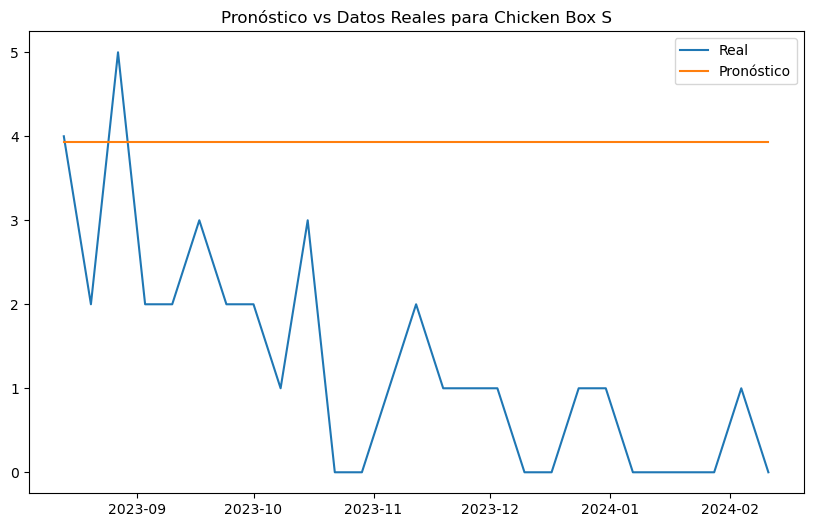

RMSE para Hamburguesa Americana: 7.164844896379102


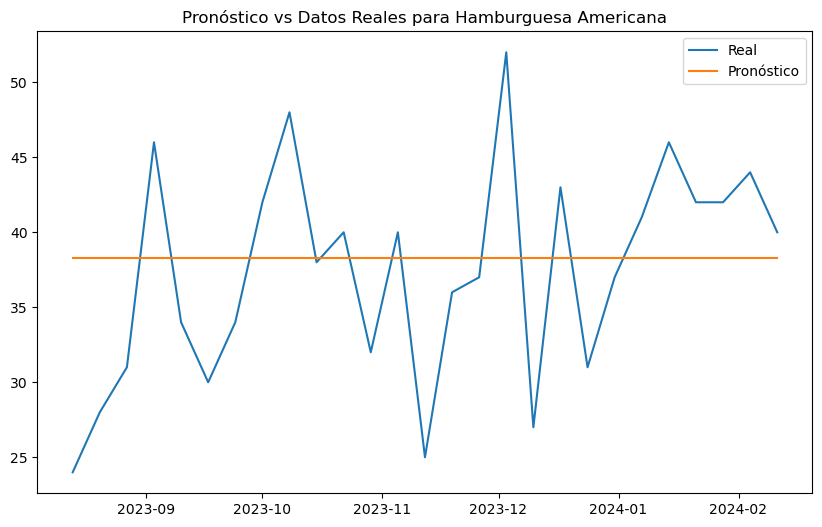

RMSE para Hamburguesa Clasica: 8.686791524272554


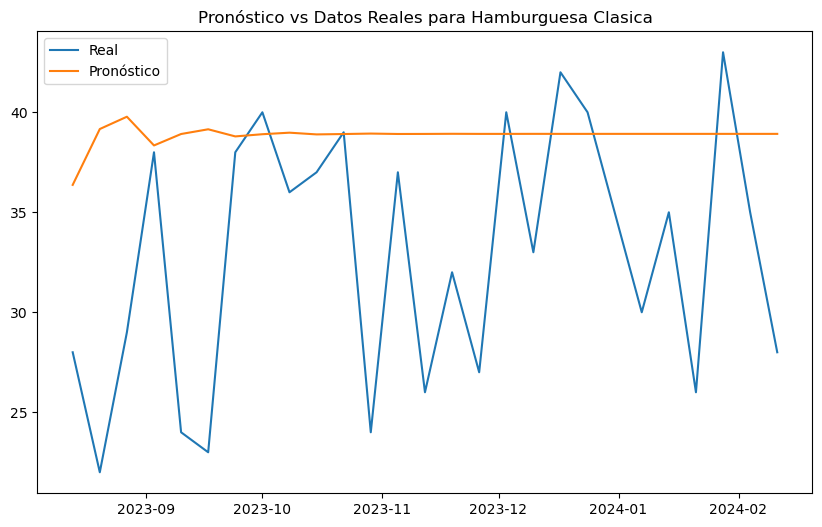

RMSE para Hamburguesa Clasica con papas promo: 1.6885801191868042


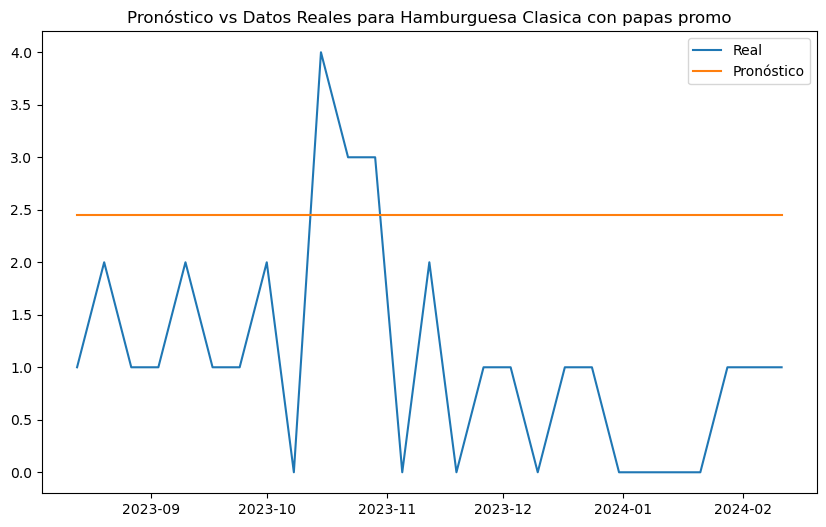

RMSE para Hamburguesa Hot: 5.230338604097285


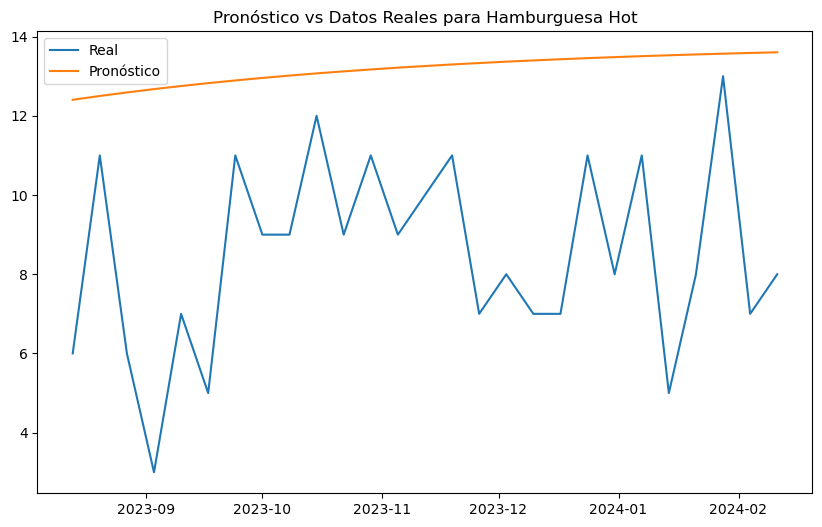

RMSE para Hamburguesa Vegetariana: 5.448875577801214


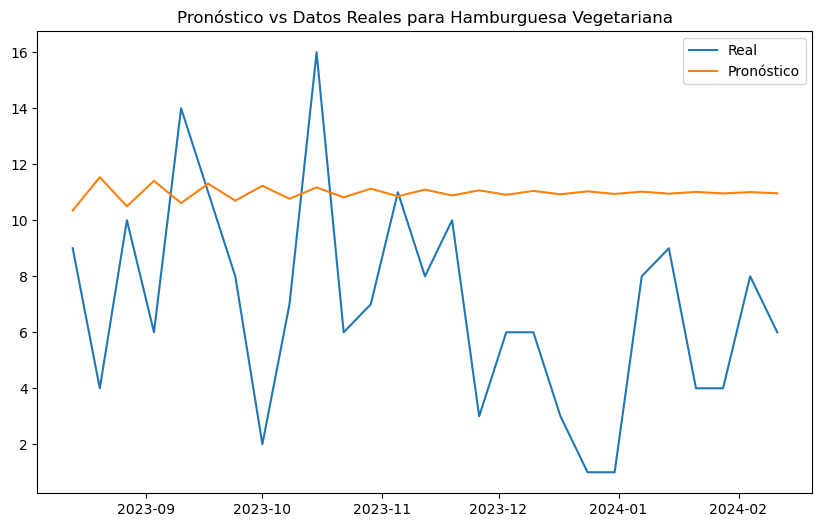

RMSE para Michelada: 9.968025153910295


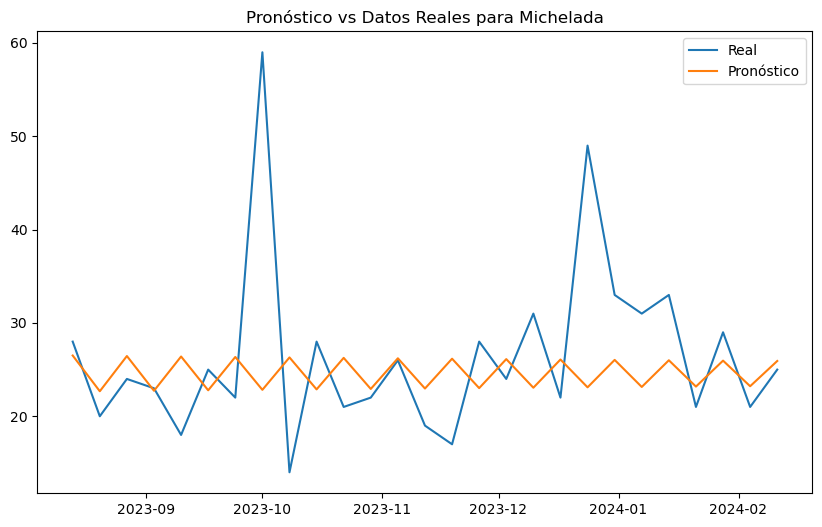

RMSE para Mistral 35: 15.67839994035748


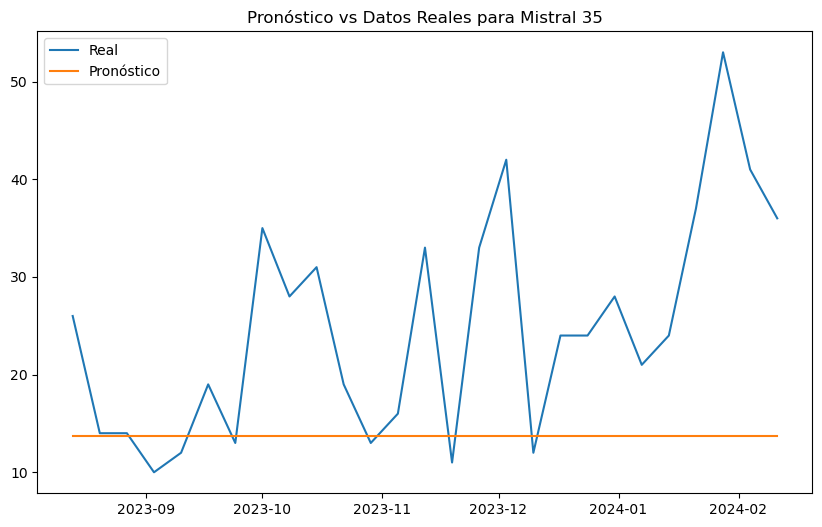

RMSE para Mistral 40: 12.749219493299993


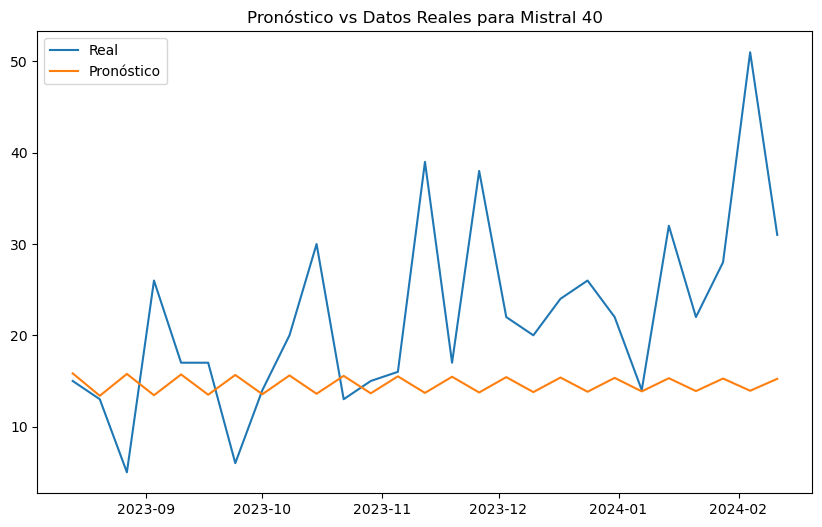

RMSE para Mojito tradicional: 8.504720422768987


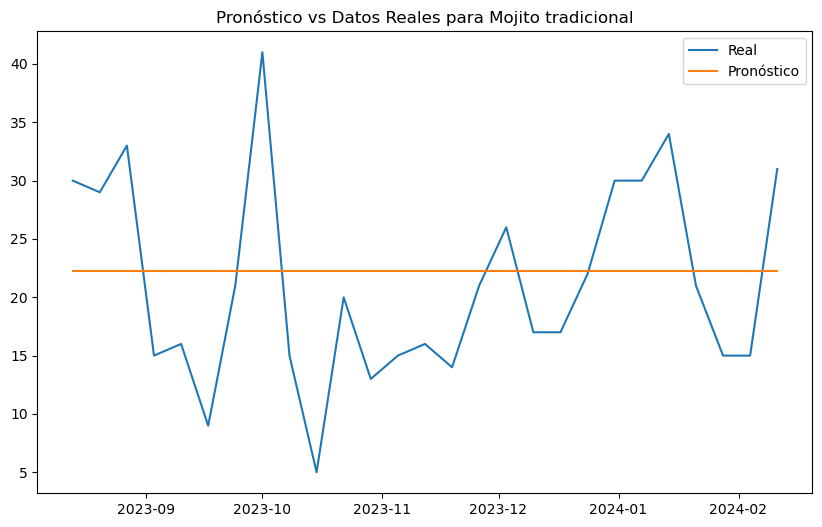

RMSE para Only Chicken: 7.201938869530774


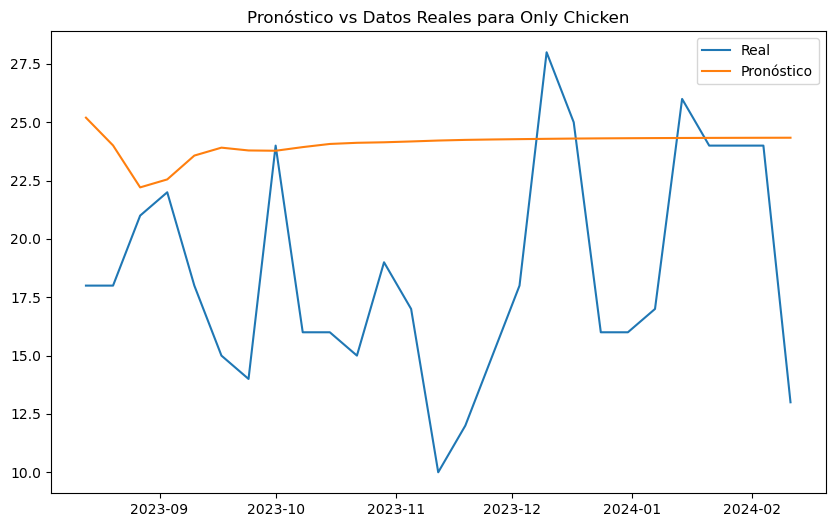

RMSE para Ramazzotti Spritz: 10.64580735737507


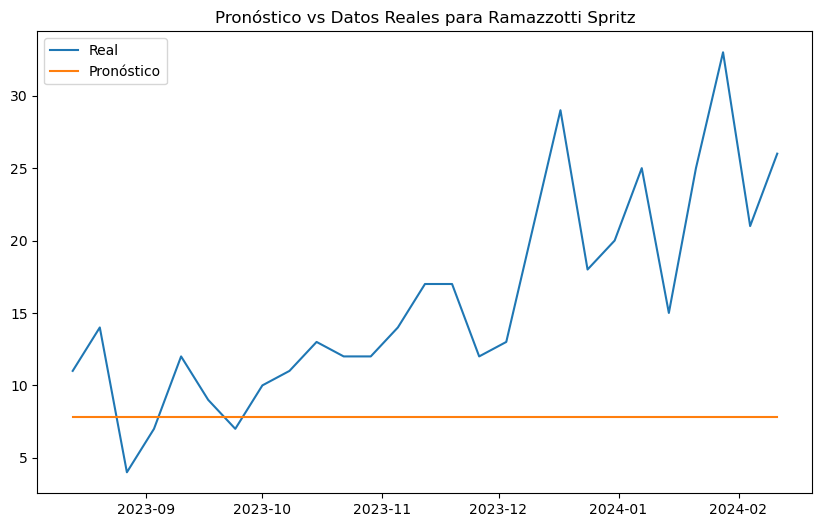

RMSE para Sandi spritz: 10.813882595771506


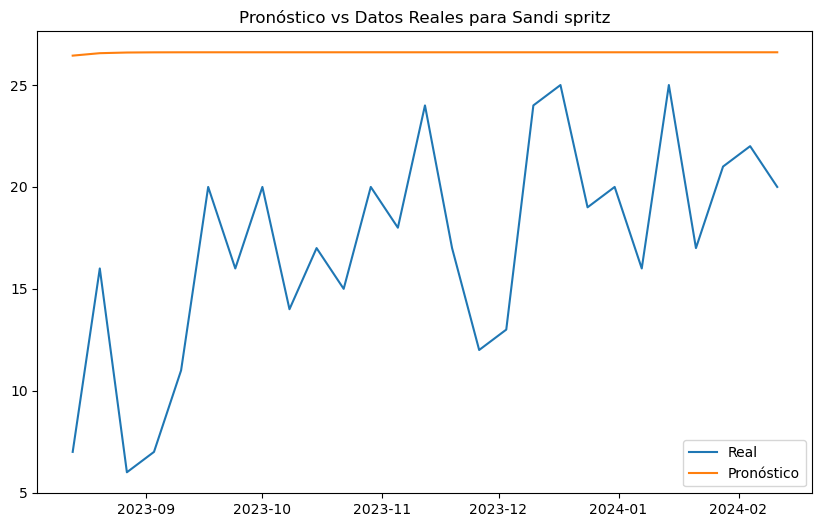

RMSE para Schop heineken: 32.931725001963606


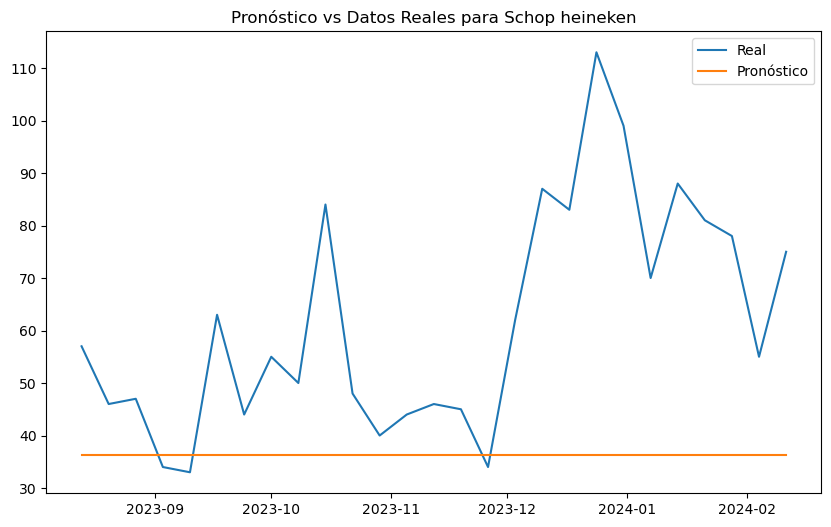

RMSE para Solsticio: 3.9968613691068953


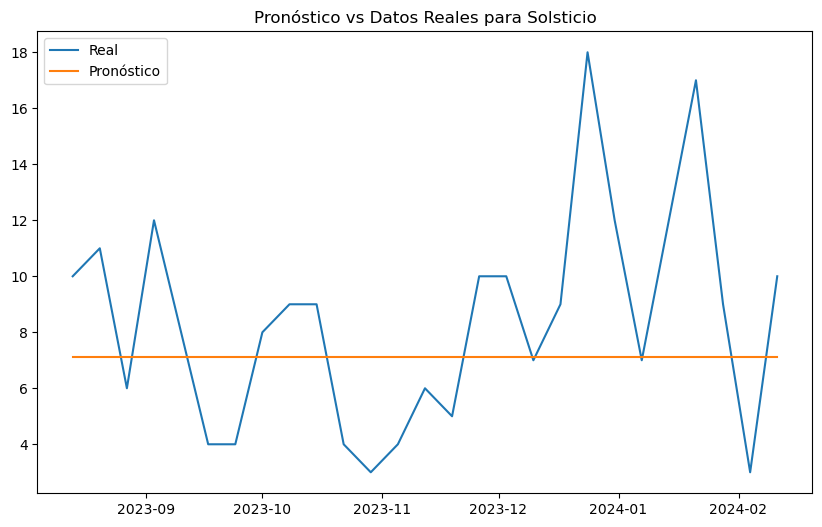

RMSE para beefie compartir: 7.251809355254553


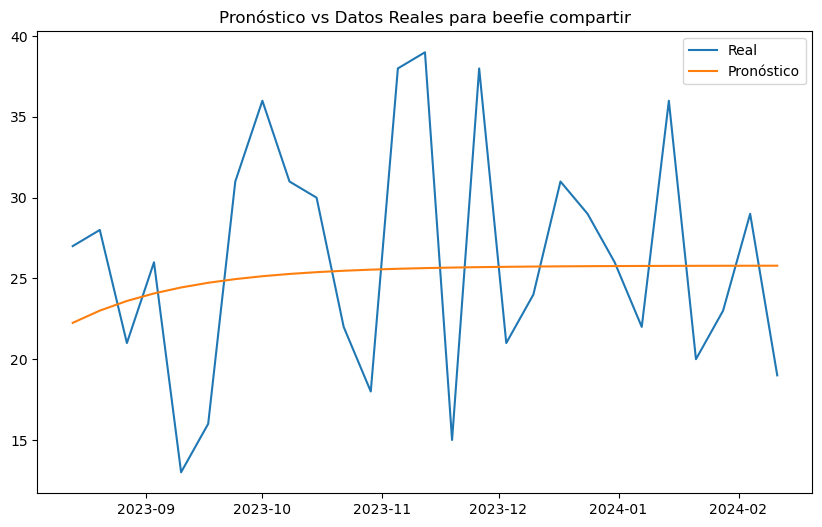

RMSE para beefie individual: 6.310947280621819


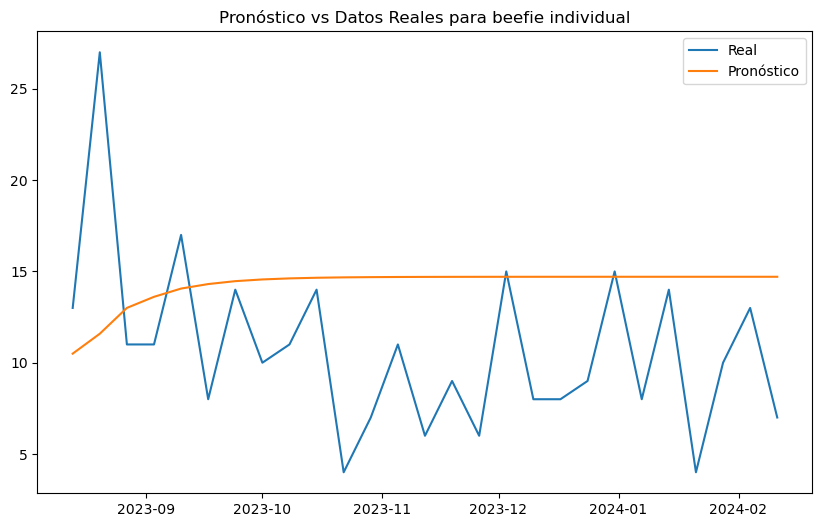

RMSE para cheese and bacon compartir: 15.43854193922903


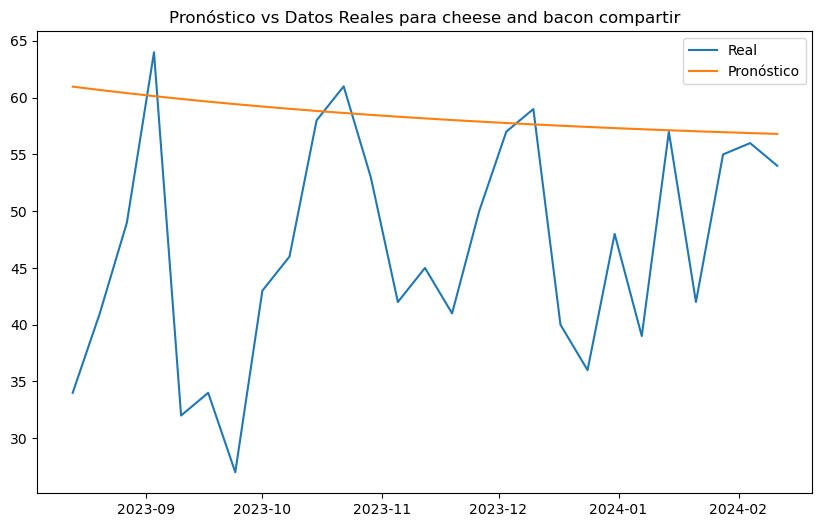

RMSE para cheese and bacon compartir promo: 2.4029841919043


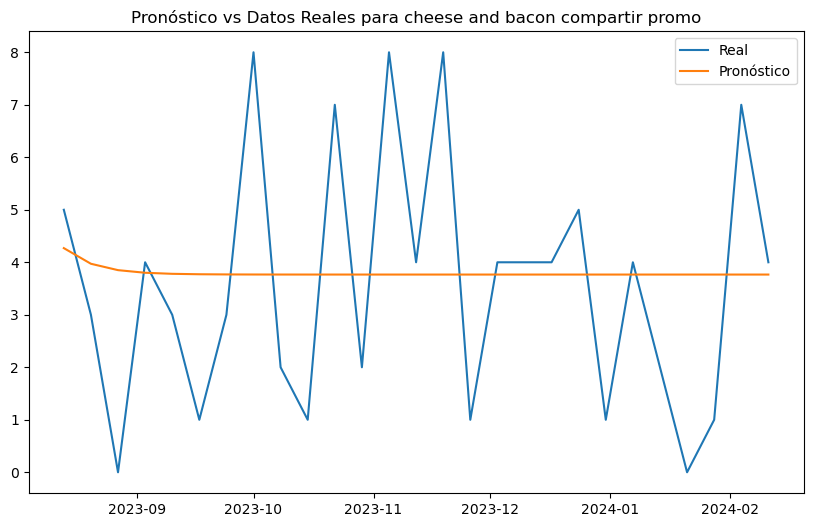

RMSE para cheese and bacon individual: 8.54139006434436


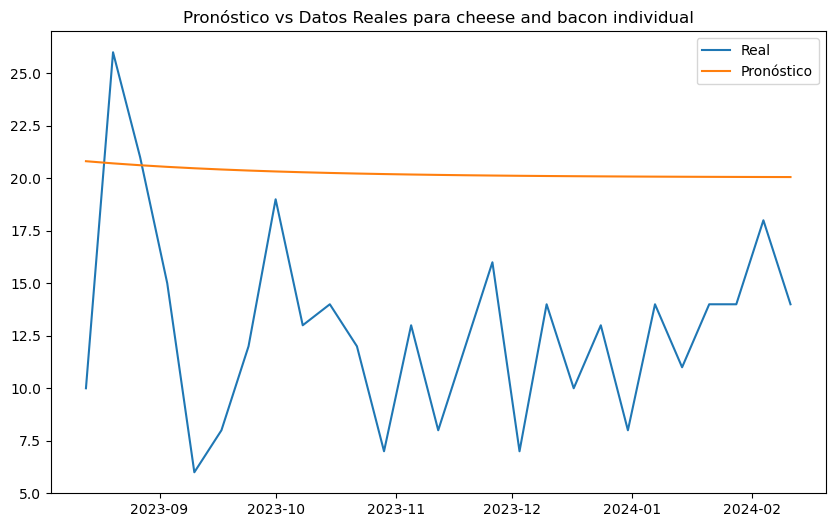

RMSE para choclo champiñon compartir: 4.314111590524982


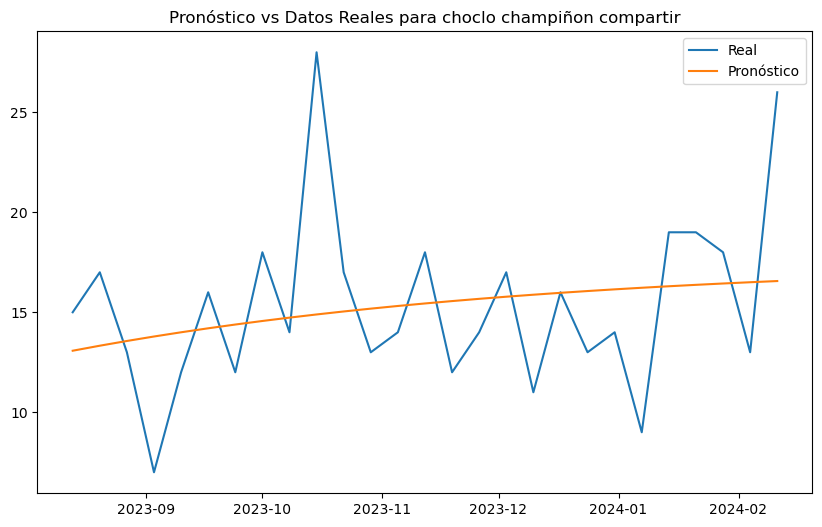

RMSE para choclo champiñon individual: 4.828681209108767


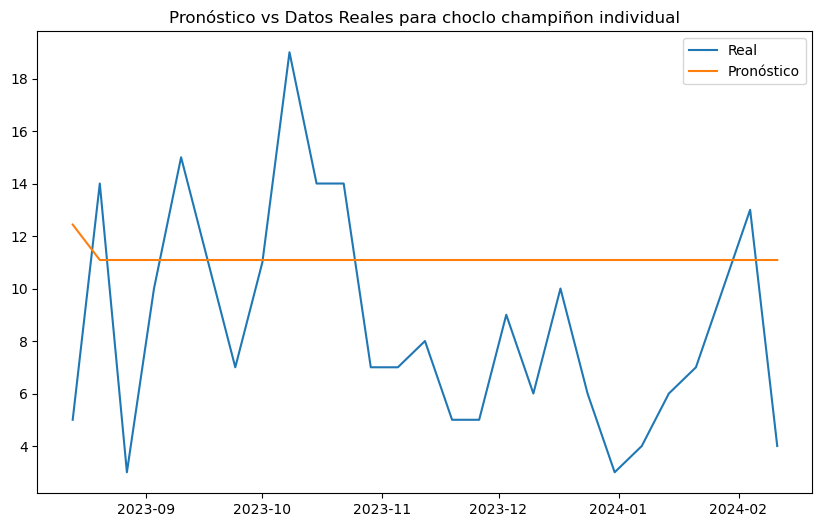

RMSE para coca cola: 7.9525194860360635


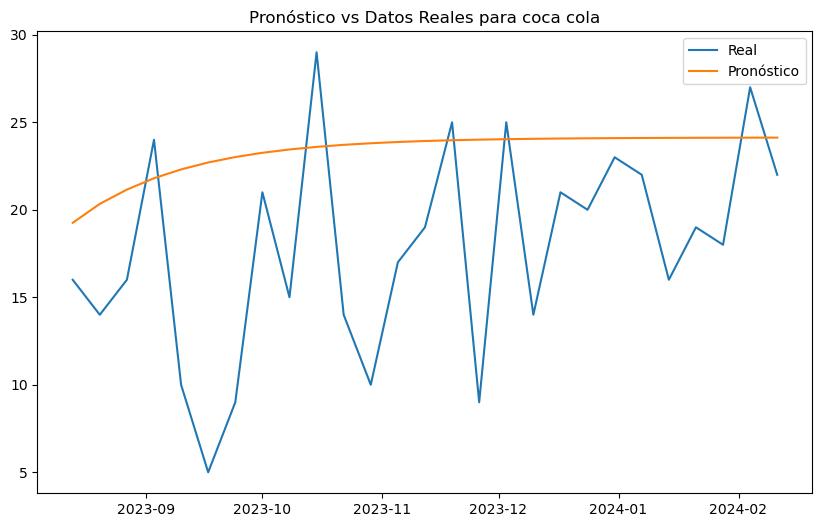

RMSE para coca cola promo: 4.125521993782812


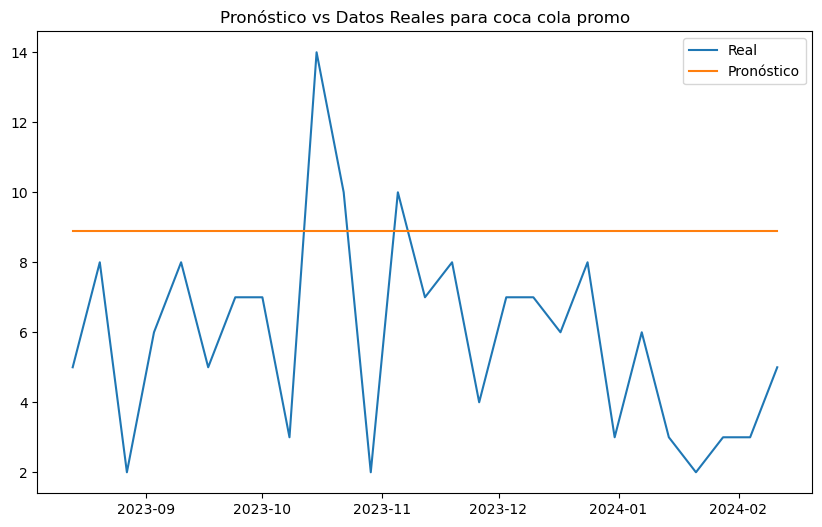

RMSE para coca cola sin azucar: 5.383424105903869


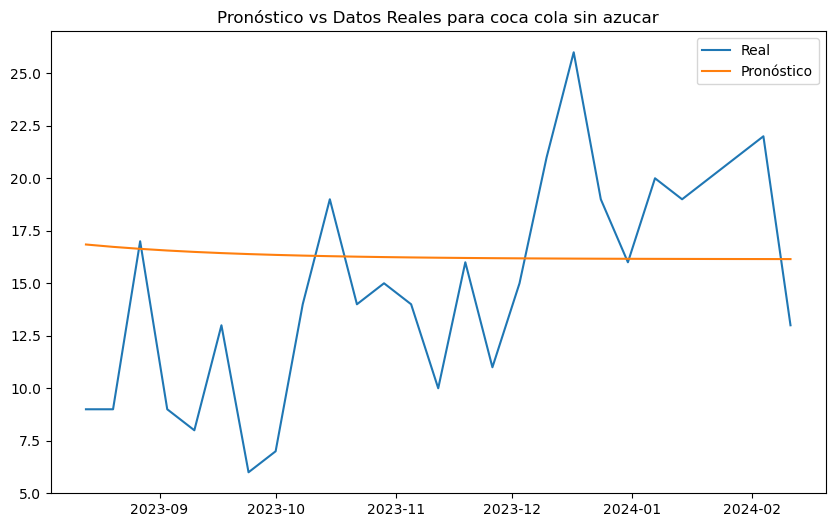

RMSE para coca cola sin azucar promo: 3.0168978208549935


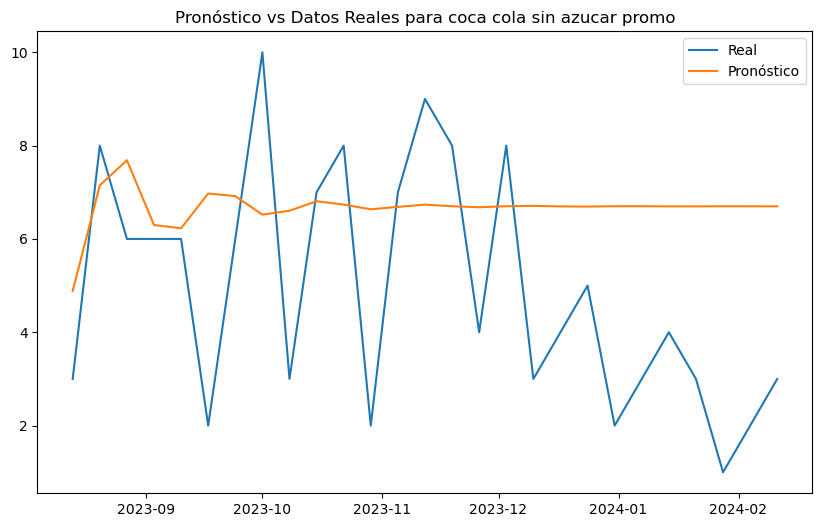

RMSE para fanta promo: 2.647626556219333


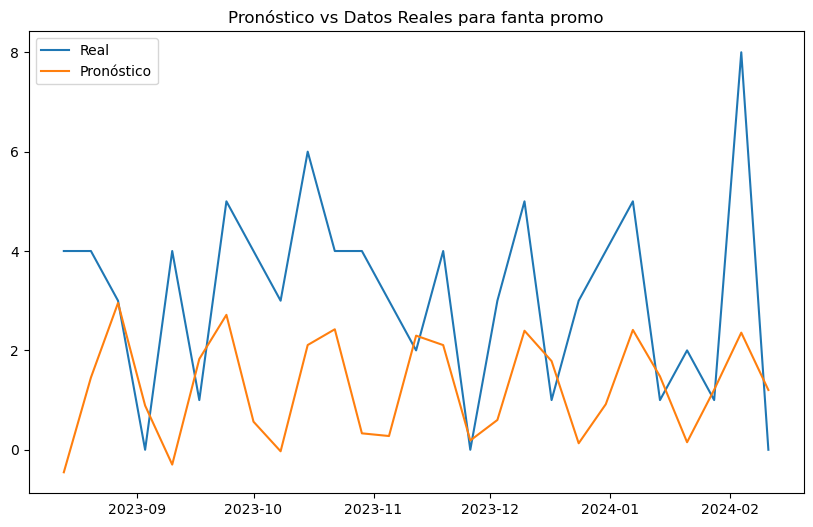

RMSE para mechada compartir: 5.532835798231709


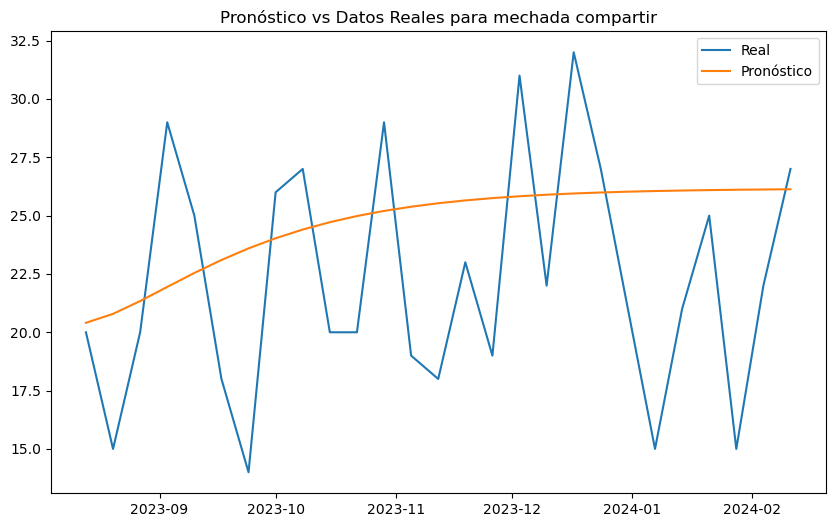

RMSE para mechada individual: 3.07327979692069


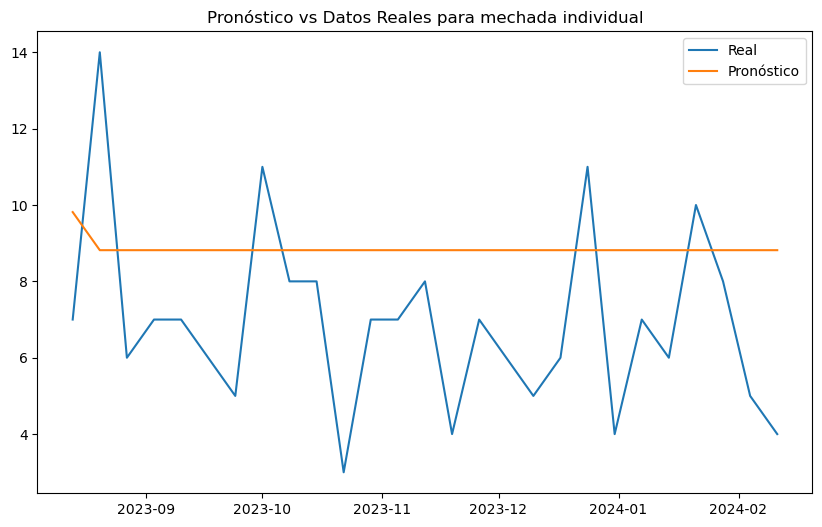

RMSE para mexa compartir: 4.546832683217925


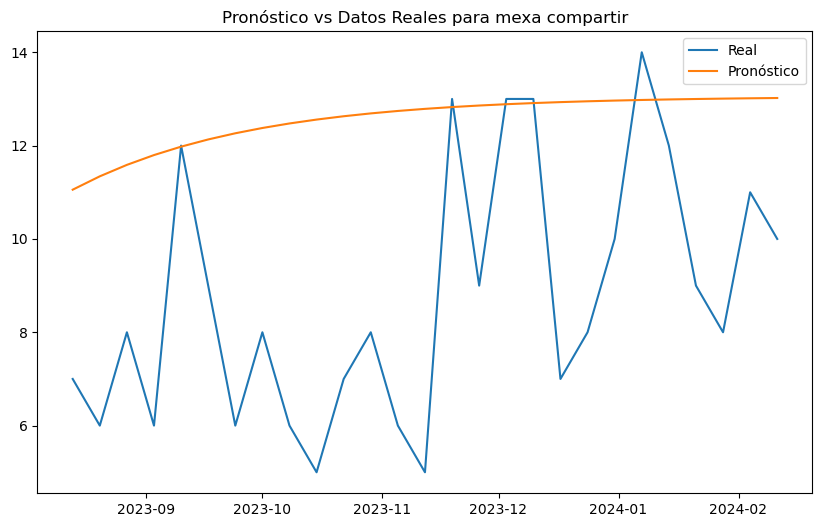

RMSE para pollo albahaca compartir: 3.3383601371966374


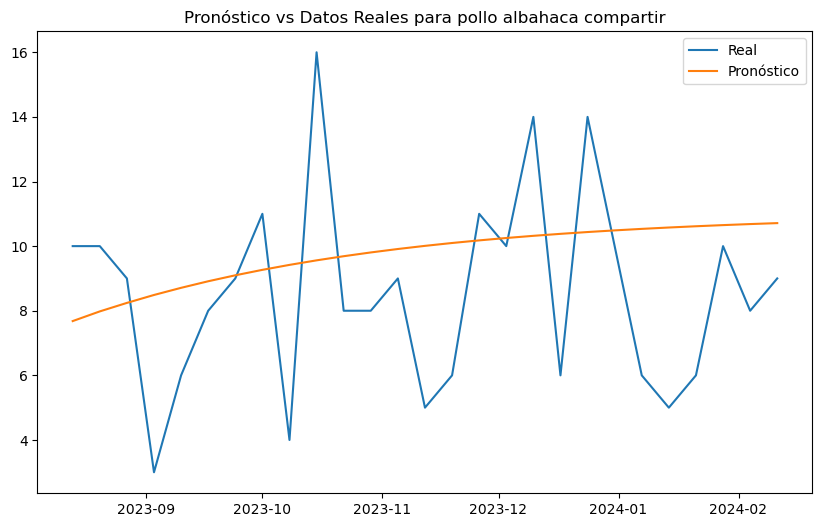

RMSE para single fries compartir: 3.4705378567141913


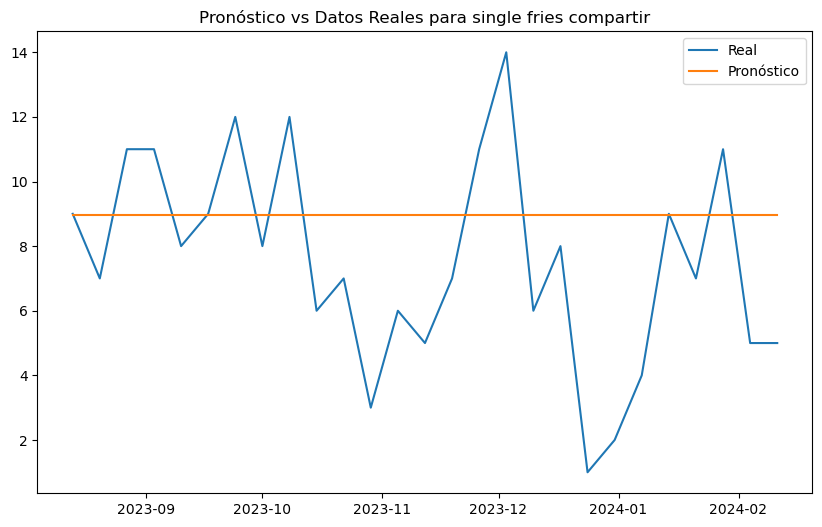

RMSE para veggie compartir: 9.072241428323617


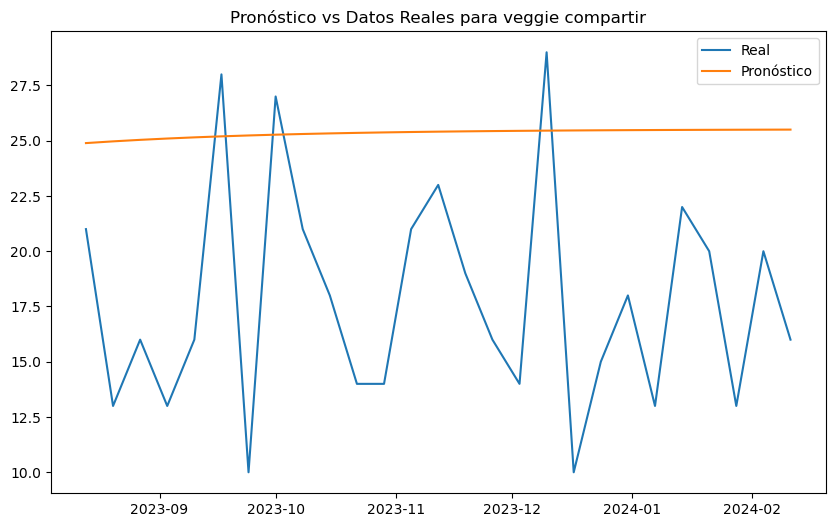

In [30]:
resultados_arima = {}
resultados_pronostico = {}
resultados_rmse = {}

for producto in df_pivot.columns:
    serie_temporal = df_pivot[producto].dropna()

    # Dividir los datos en un conjunto de entrenamiento y otro de prueba
    split_point = int(len(serie_temporal) * 0.8)
    train, test = serie_temporal[:split_point], serie_temporal[split_point:]

    # Ajustar el modelo ARIMA en el conjunto de entrenamiento
    modelo_arima = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_order=None)

    # Almacenar el modelo
    resultados_arima[producto] = modelo_arima

    # Realizar predicciones para el mismo número de períodos que el conjunto de prueba
    pronostico = modelo_arima.predict(n_periods=len(test))

    # Almacenar el pronóstico
    resultados_pronostico[producto] = pronostico

    # Calcular y almacenar el RMSE
    rmse = np.sqrt(np.mean((pronostico - test.values)**2))
    resultados_rmse[producto] = rmse

    # Imprimir el RMSE para cada producto
    print(f"RMSE para {producto}: {rmse}")

    # Opcional: graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test, label='Real')
    plt.plot(test.index, pronostico, label='Pronóstico')
    plt.title(f'Pronóstico vs Datos Reales para {producto}')
    plt.legend()
    plt.show()

In [31]:
resultados_rmse

{'2 SCHOP HEINEKEN': 10.8916220591272,
 '2 hamburguesas con papas + 2 bebidas': 1.5594131799485946,
 '2 papas grandes + 2 bebidas': 3.2193635528041415,
 'Cheddar': 3.95497583080885,
 'Chelada': 6.734981365425862,
 'Chicken Box S': 2.934716162062134,
 'Hamburguesa Americana': 7.164844896379102,
 'Hamburguesa Clasica': 8.686791524272554,
 'Hamburguesa Clasica con papas promo': 1.6885801191868042,
 'Hamburguesa Hot': 5.230338604097285,
 'Hamburguesa Vegetariana': 5.448875577801214,
 'Michelada': 9.968025153910295,
 'Mistral 35': 15.67839994035748,
 'Mistral 40': 12.749219493299993,
 'Mojito tradicional': 8.504720422768987,
 'Only Chicken': 7.201938869530774,
 'Ramazzotti Spritz': 10.64580735737507,
 'Sandi spritz': 10.813882595771506,
 'Schop heineken': 32.931725001963606,
 'Solsticio': 3.9968613691068953,
 'beefie compartir': 7.251809355254553,
 'beefie individual': 6.310947280621819,
 'cheese and bacon compartir': 15.43854193922903,
 'cheese and bacon compartir promo': 2.4029841919043,


RMSE de validación cruzada para 2 SCHOP HEINEKEN: 8.594


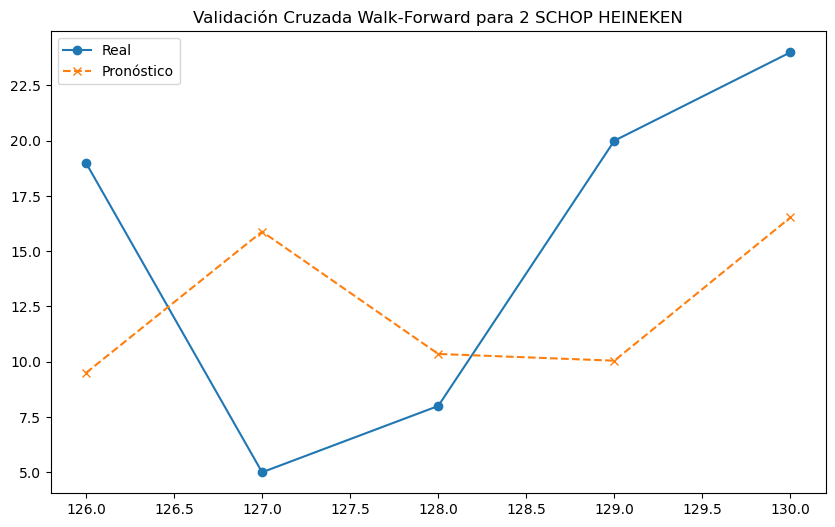

RMSE de validación cruzada para 2 hamburguesas con papas + 2 bebidas: 0.760


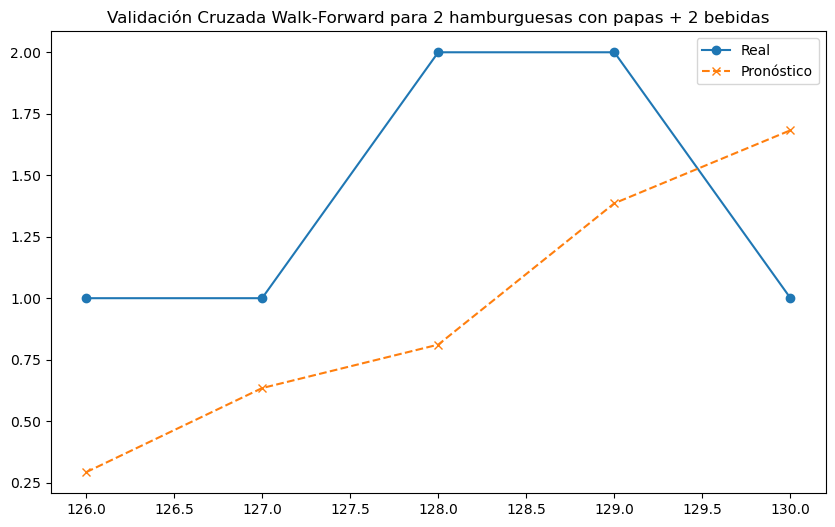

RMSE de validación cruzada para 2 papas grandes + 2 bebidas: 3.365


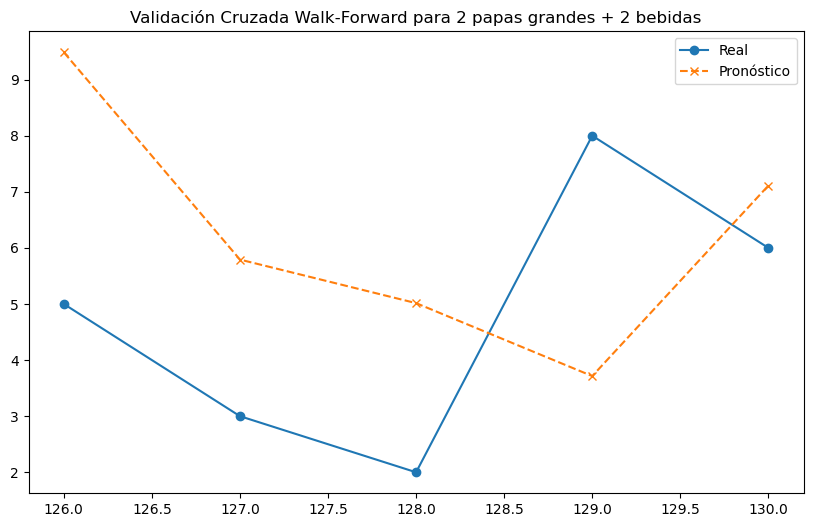

RMSE de validación cruzada para Cheddar: 4.905


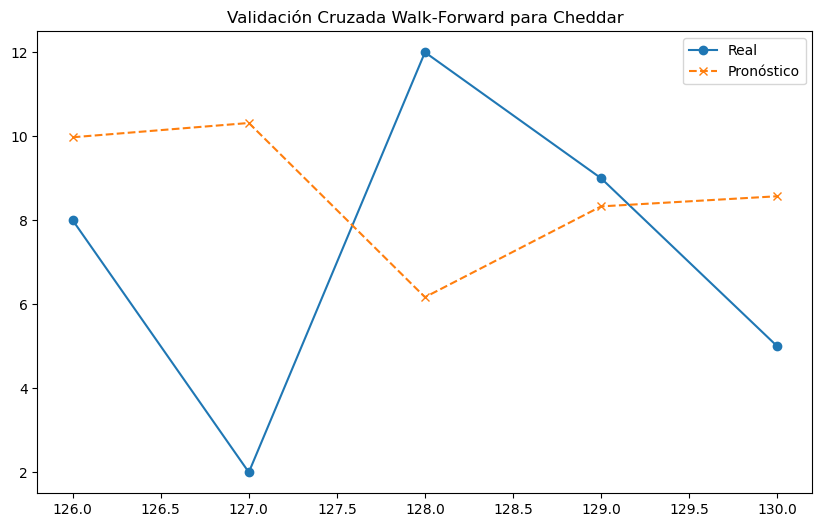

RMSE de validación cruzada para Chelada: 8.263


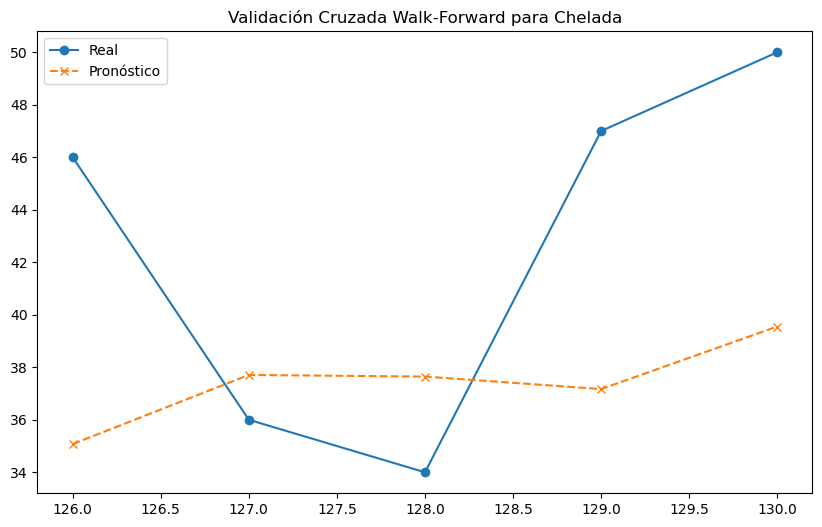

RMSE de validación cruzada para Chicken Box S: 0.526


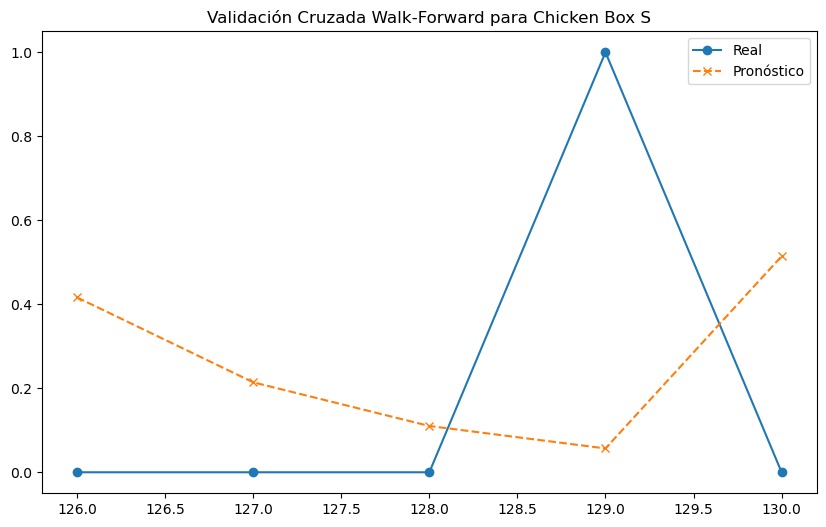

RMSE de validación cruzada para Hamburguesa Americana: 3.832


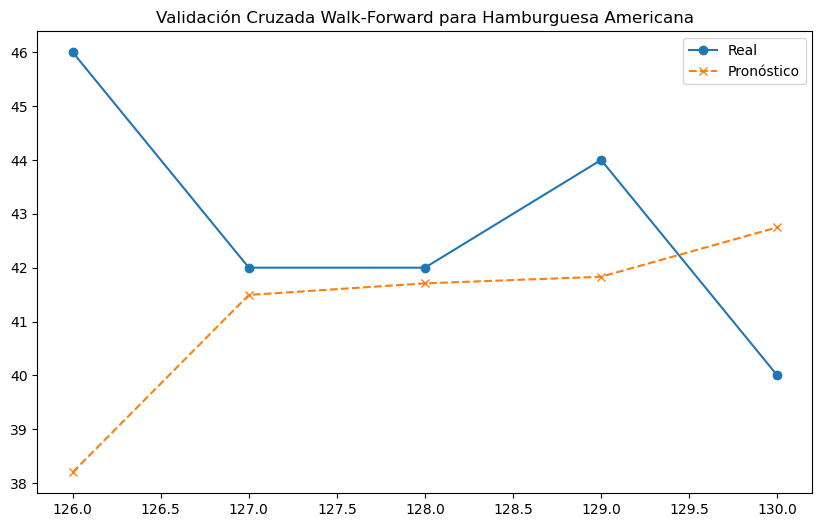

RMSE de validación cruzada para Hamburguesa Clasica: 7.566


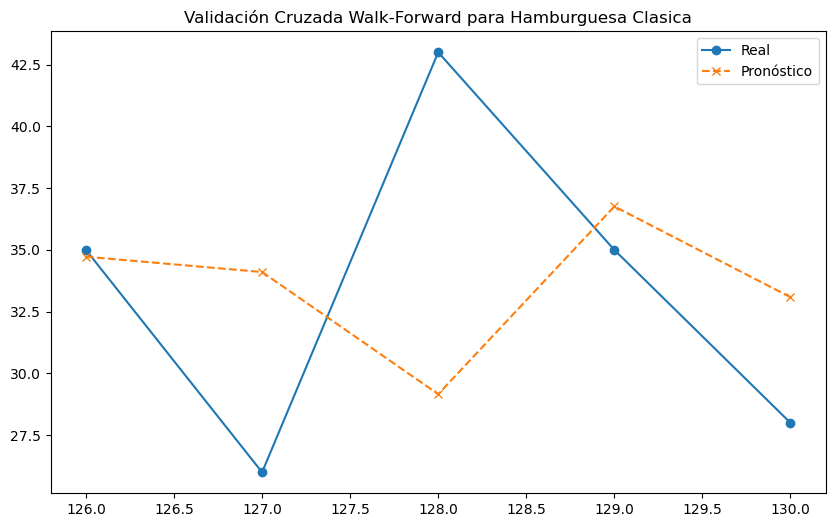

RMSE de validación cruzada para Hamburguesa Clasica con papas promo: 1.278


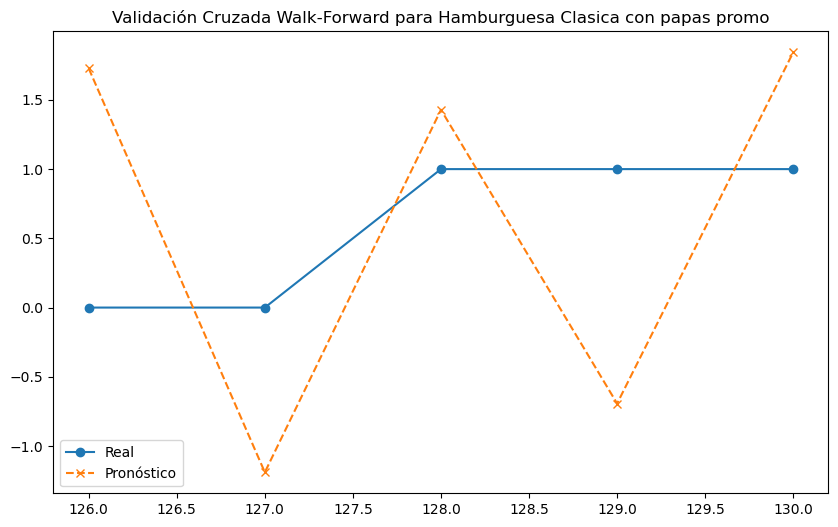

RMSE de validación cruzada para Hamburguesa Hot: 3.310


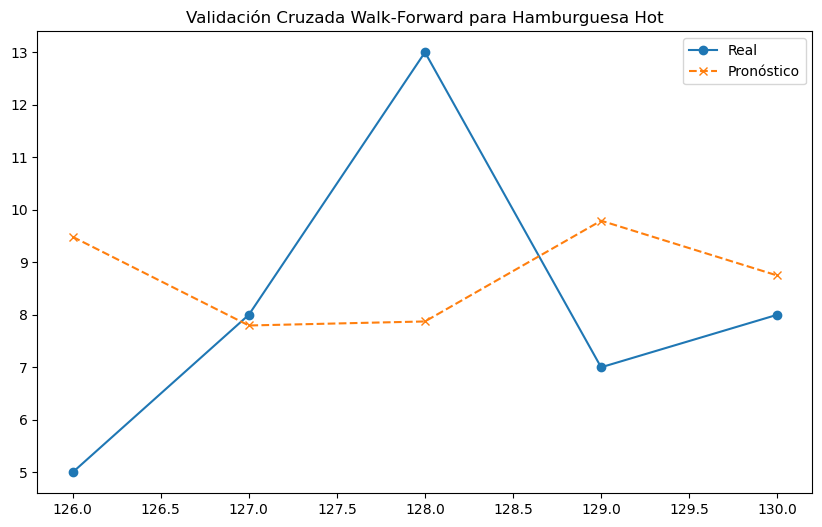

RMSE de validación cruzada para Hamburguesa Vegetariana: 2.893


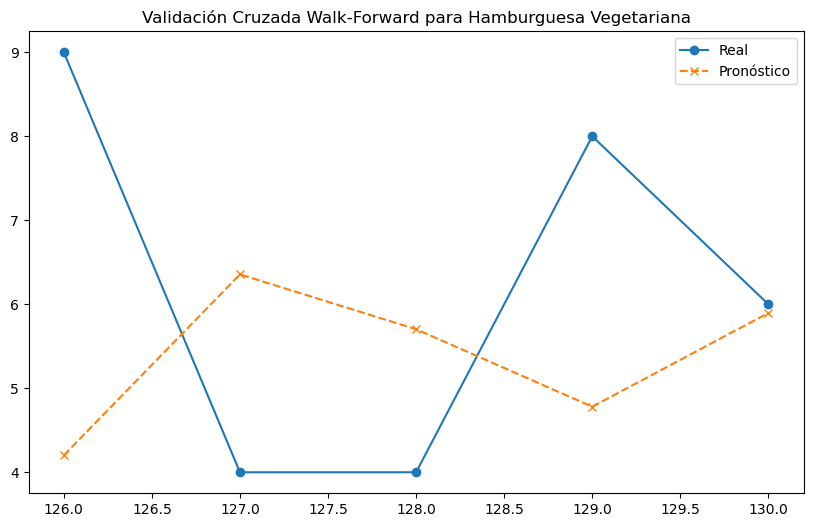

RMSE de validación cruzada para Michelada: 7.030


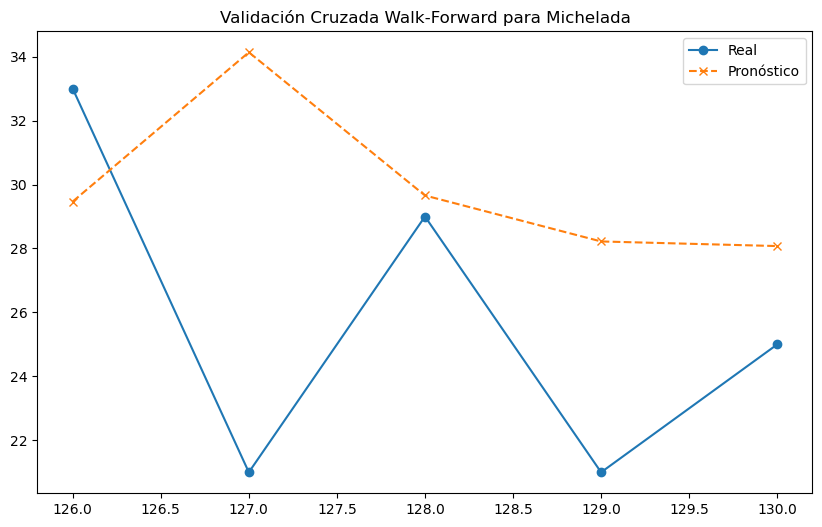

RMSE de validación cruzada para Mistral 35: 12.860


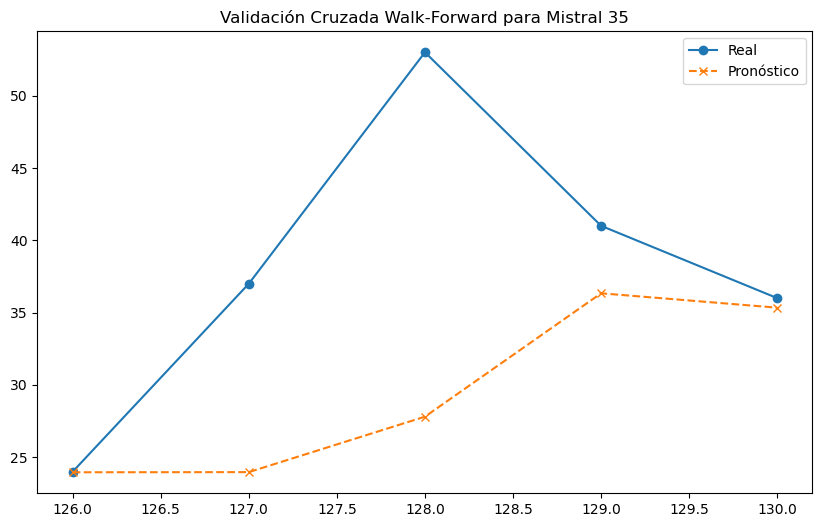

RMSE de validación cruzada para Mistral 40: 13.196


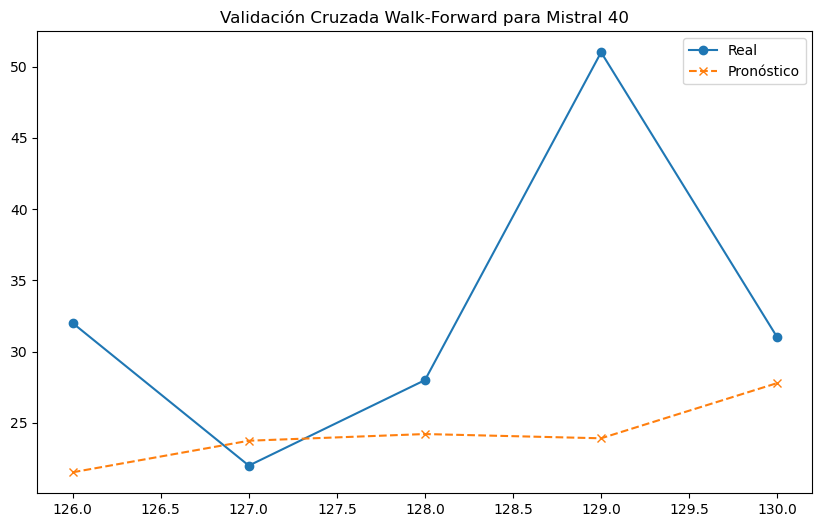

RMSE de validación cruzada para Mojito tradicional: 8.413


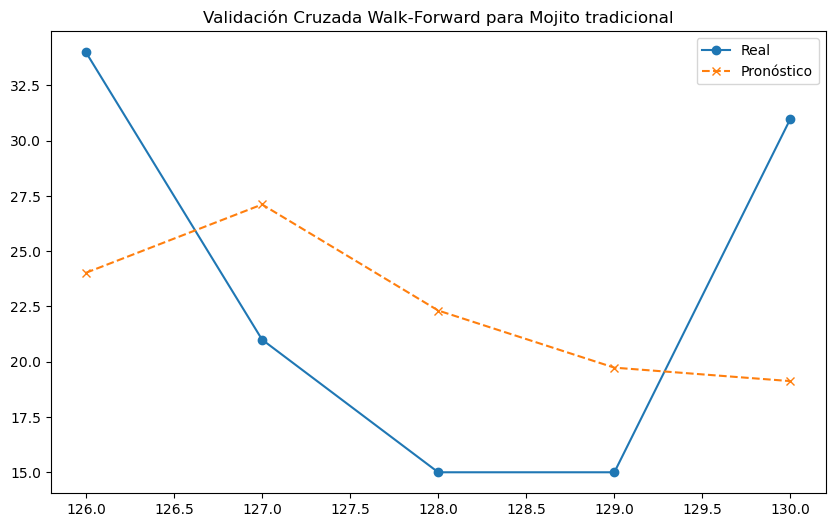

RMSE de validación cruzada para Only Chicken: 5.417


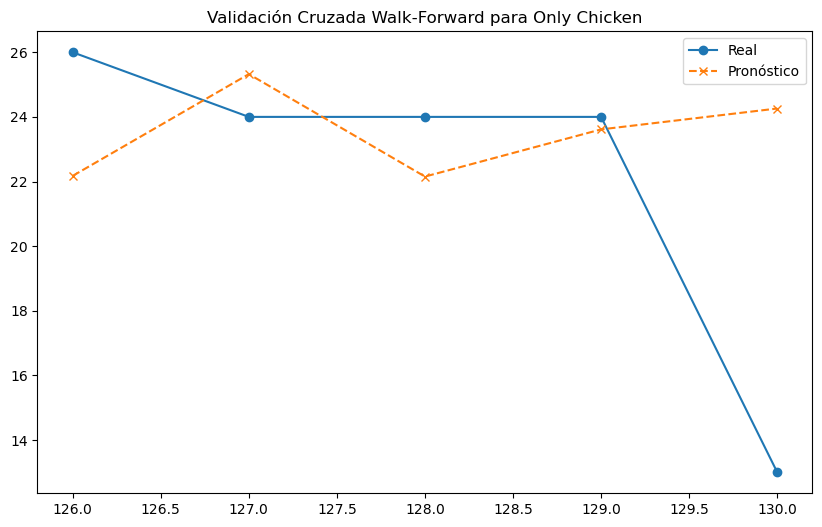

RMSE de validación cruzada para Ramazzotti Spritz: 6.719


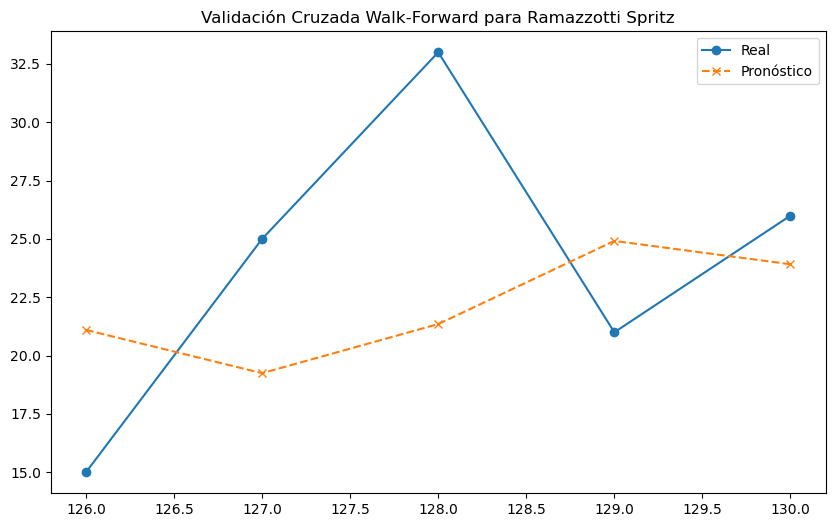

RMSE de validación cruzada para Sandi spritz: 4.725


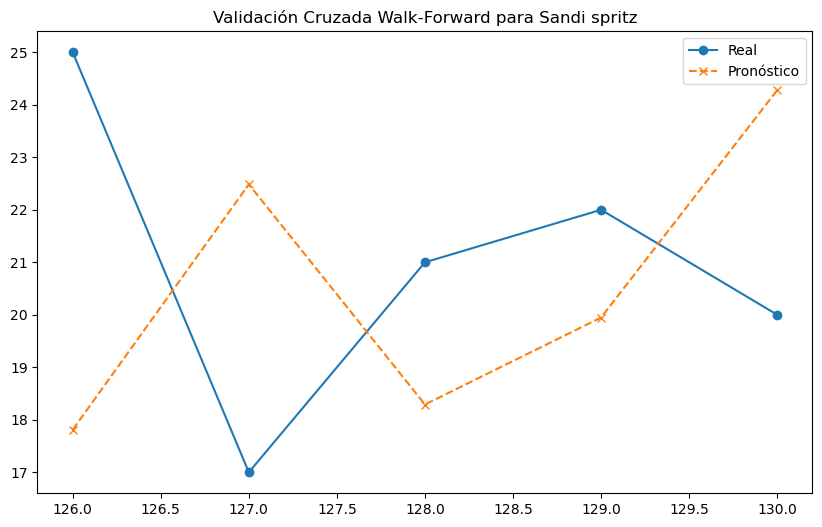

RMSE de validación cruzada para Schop heineken: 12.519


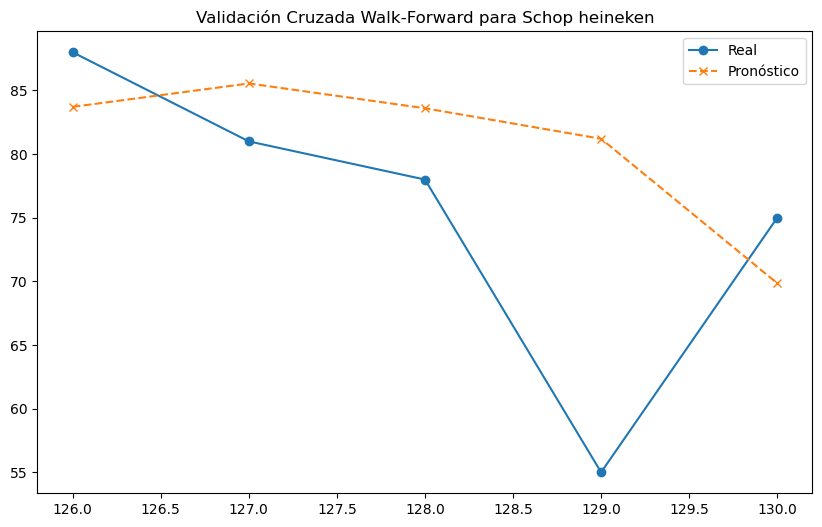

RMSE de validación cruzada para Solsticio: 5.071


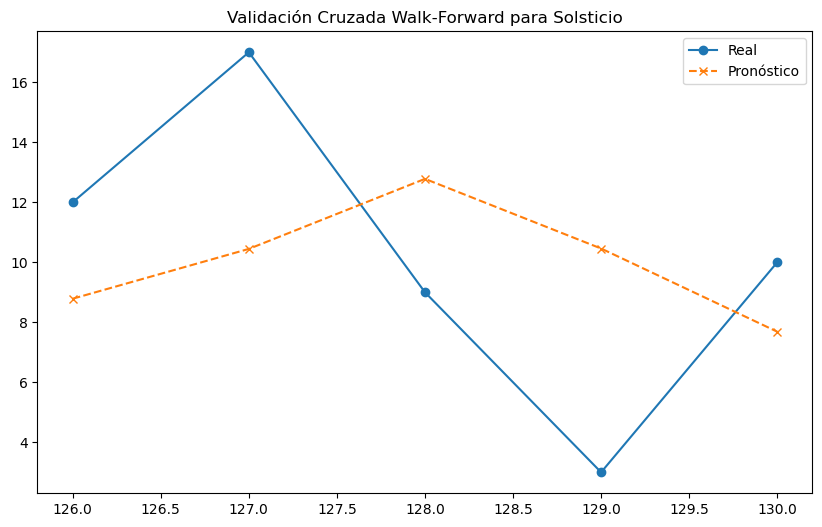

RMSE de validación cruzada para beefie compartir: 7.160


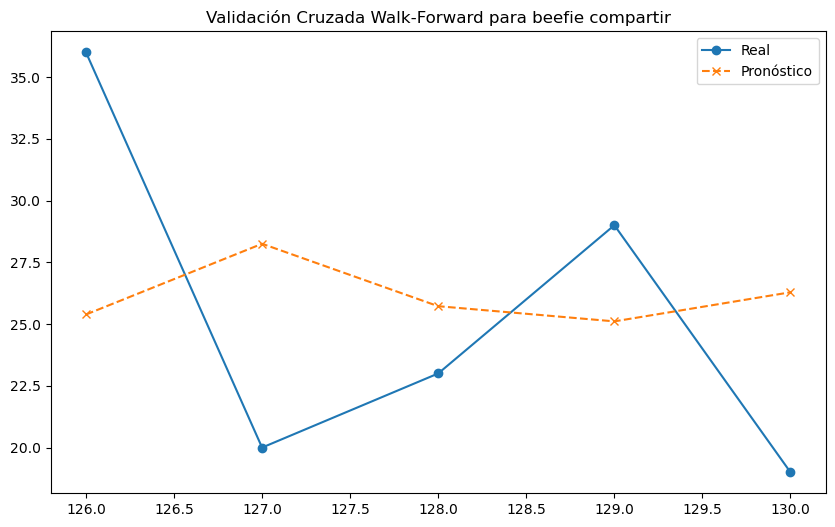

RMSE de validación cruzada para beefie individual: 4.806


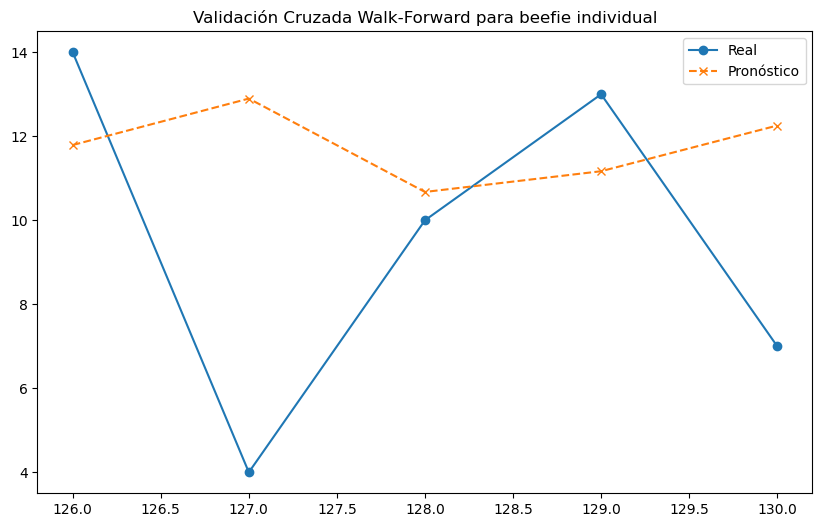

RMSE de validación cruzada para cheese and bacon compartir: 8.601


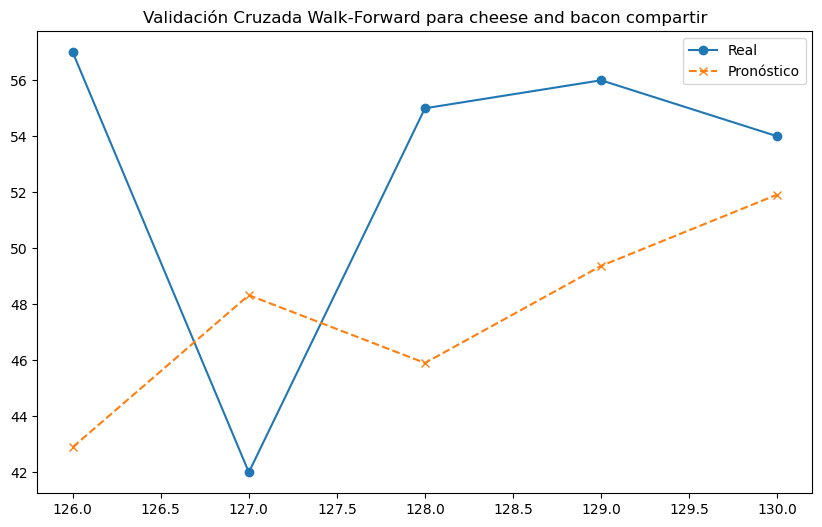

RMSE de validación cruzada para cheese and bacon compartir promo: 2.780


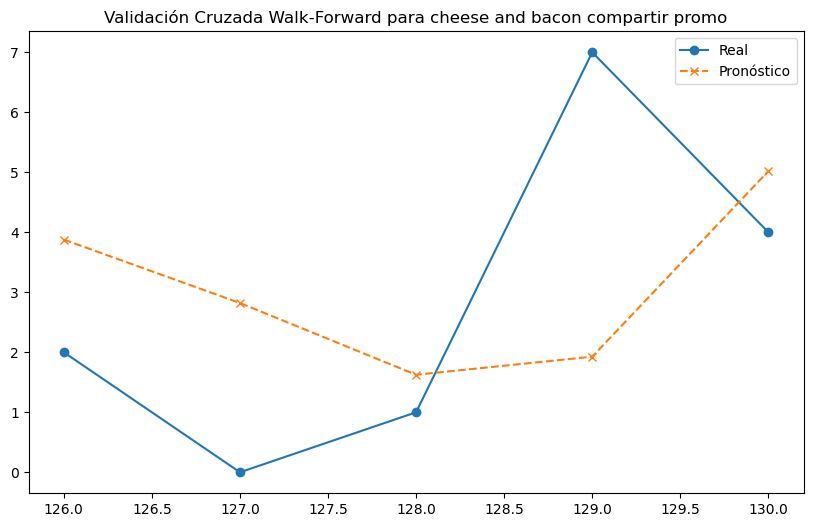

RMSE de validación cruzada para cheese and bacon individual: 2.667


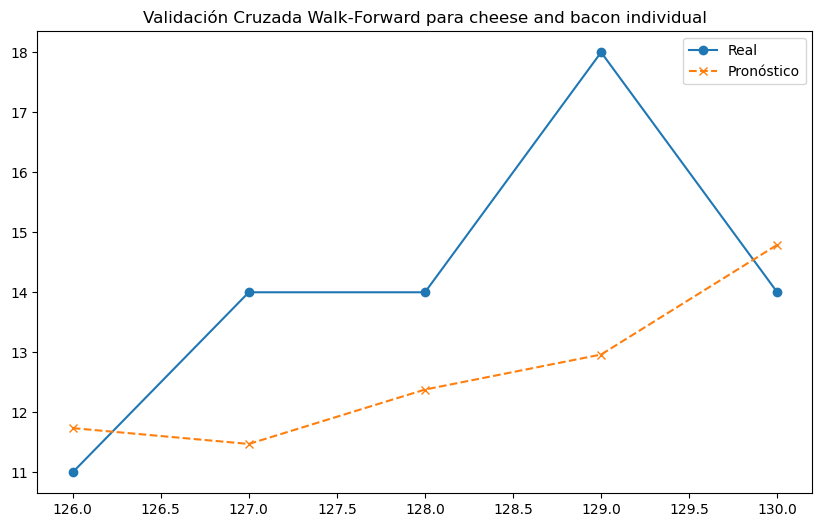

RMSE de validación cruzada para choclo champiñon compartir: 6.137


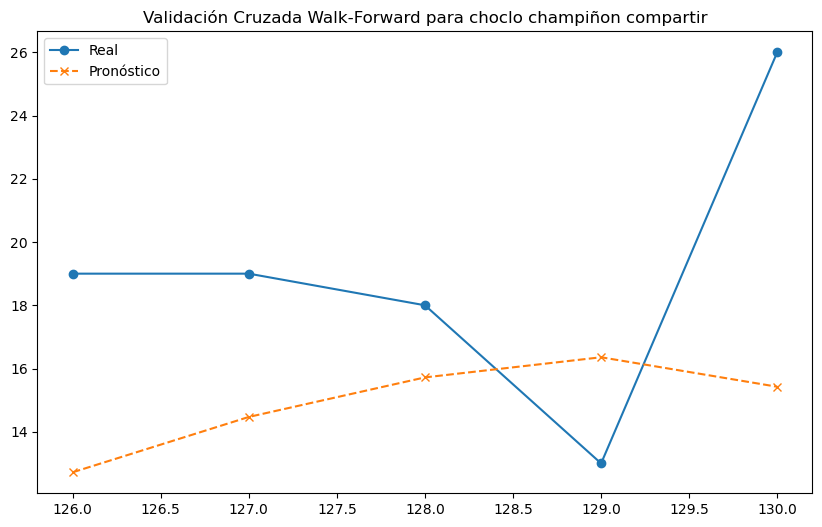

RMSE de validación cruzada para choclo champiñon individual: 3.444


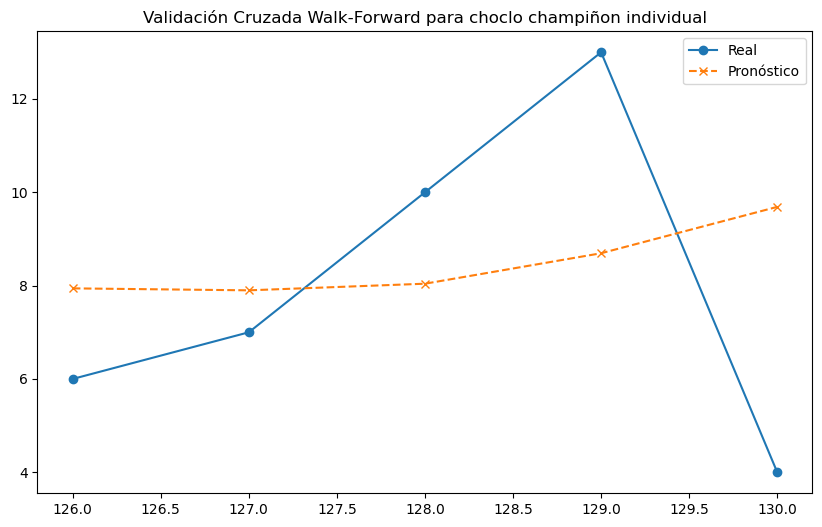

RMSE de validación cruzada para coca cola: 4.509


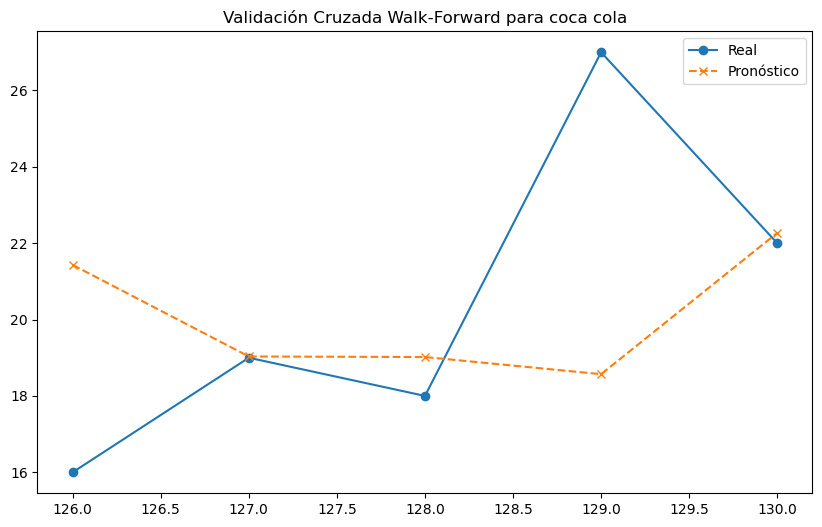

RMSE de validación cruzada para coca cola promo: 1.693


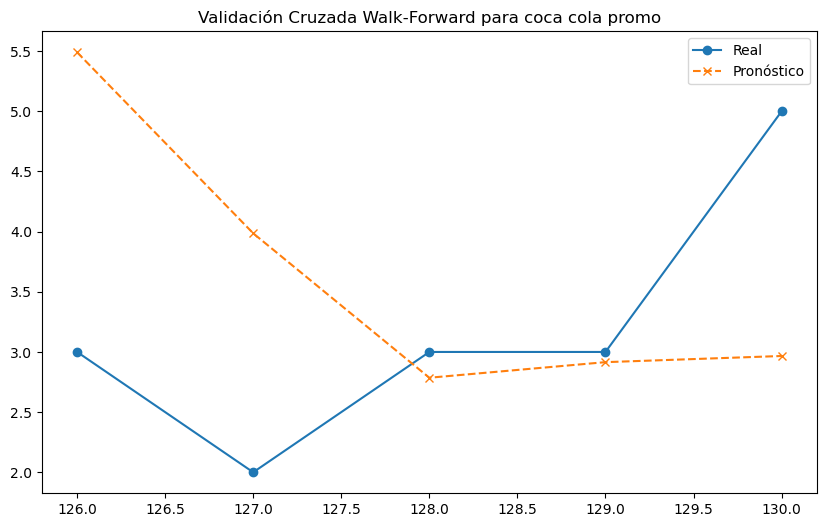

RMSE de validación cruzada para coca cola sin azucar: 3.559


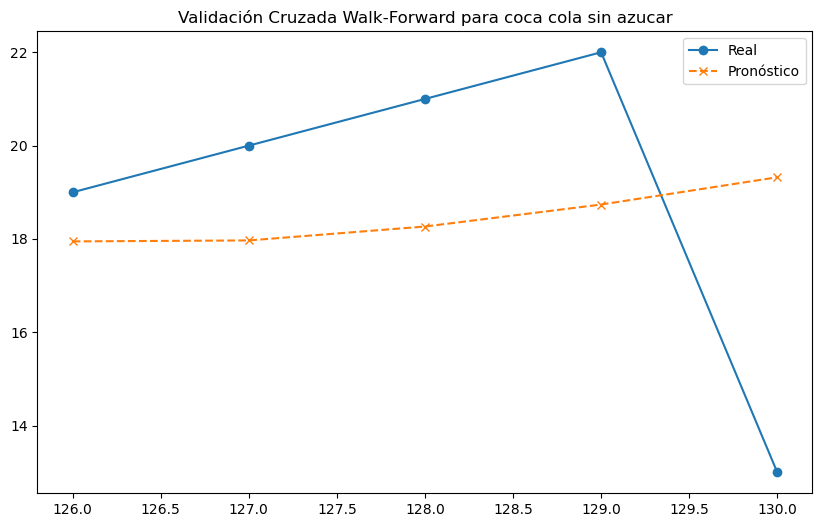

RMSE de validación cruzada para coca cola sin azucar promo: 0.784


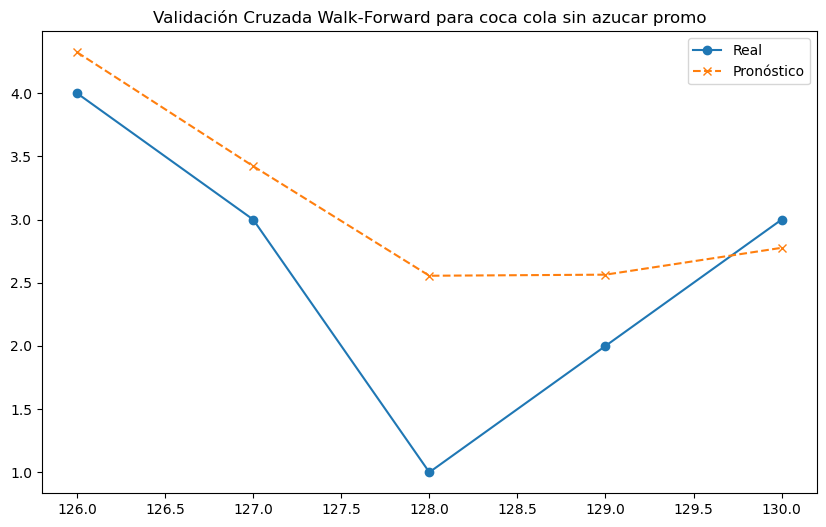

RMSE de validación cruzada para fanta promo: 4.663


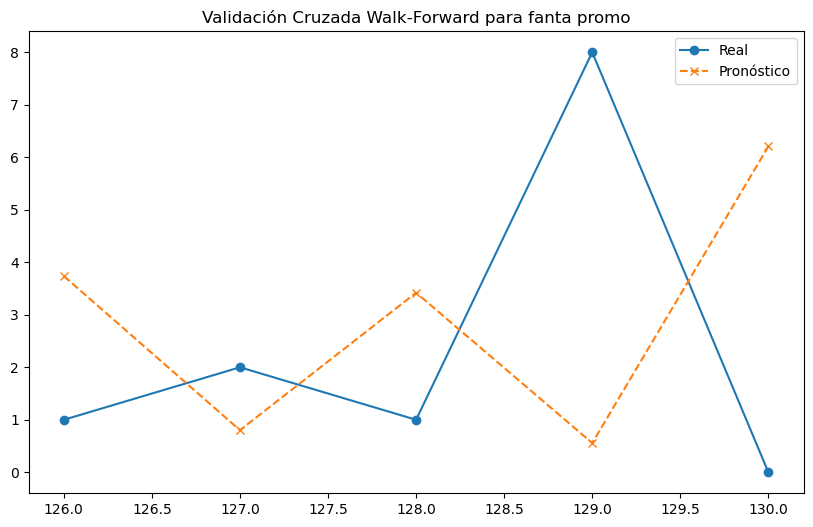

RMSE de validación cruzada para mechada compartir: 3.987


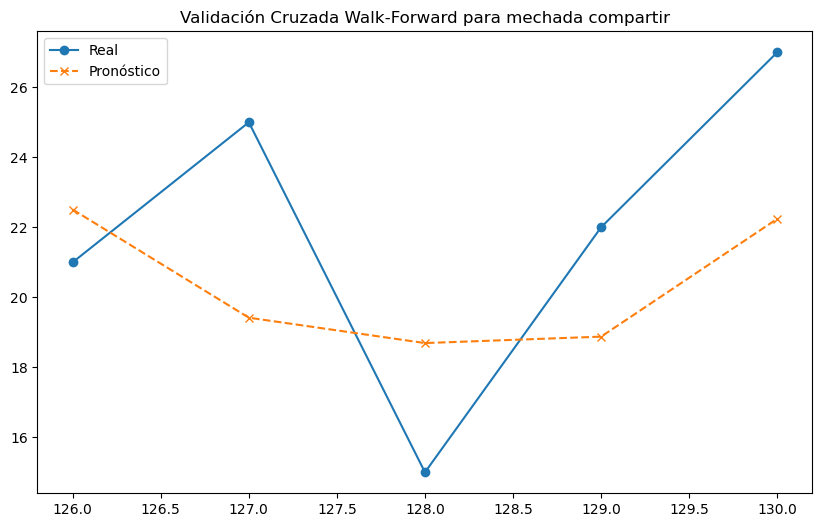

RMSE de validación cruzada para mechada individual: 2.226


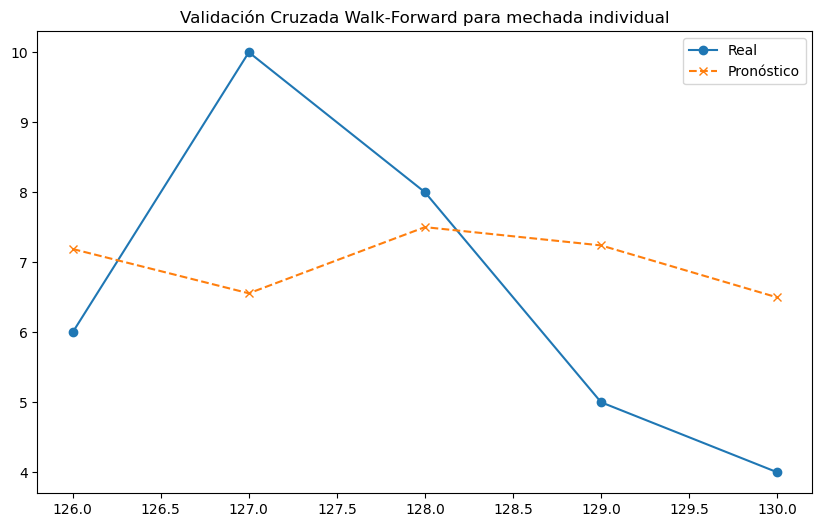

RMSE de validación cruzada para mexa compartir: 1.473


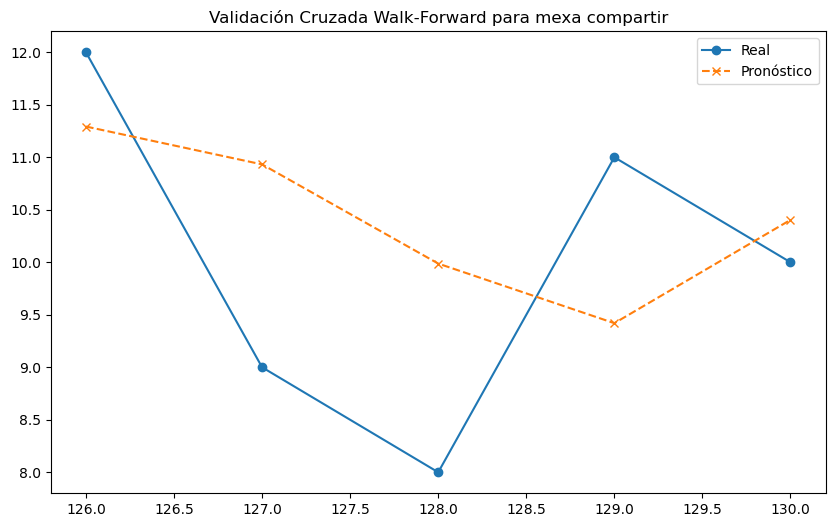

RMSE de validación cruzada para pollo albahaca compartir: 2.366


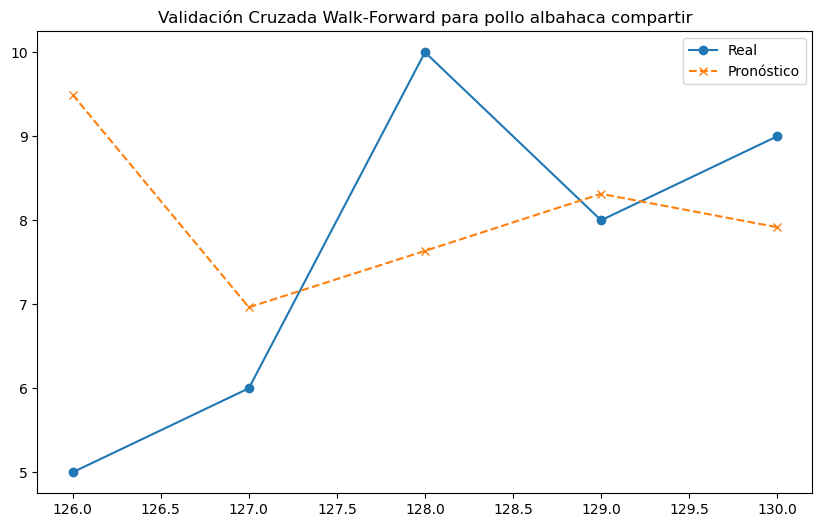

RMSE de validación cruzada para single fries compartir: 3.443


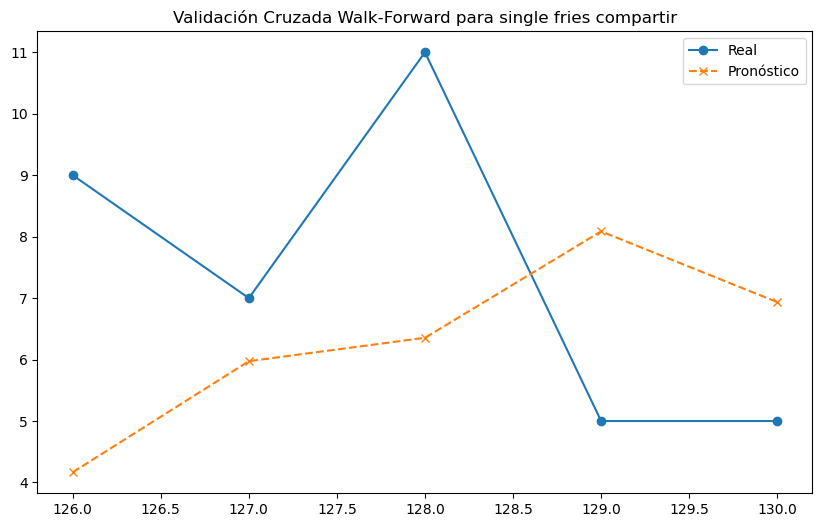

RMSE de validación cruzada para veggie compartir: 4.130


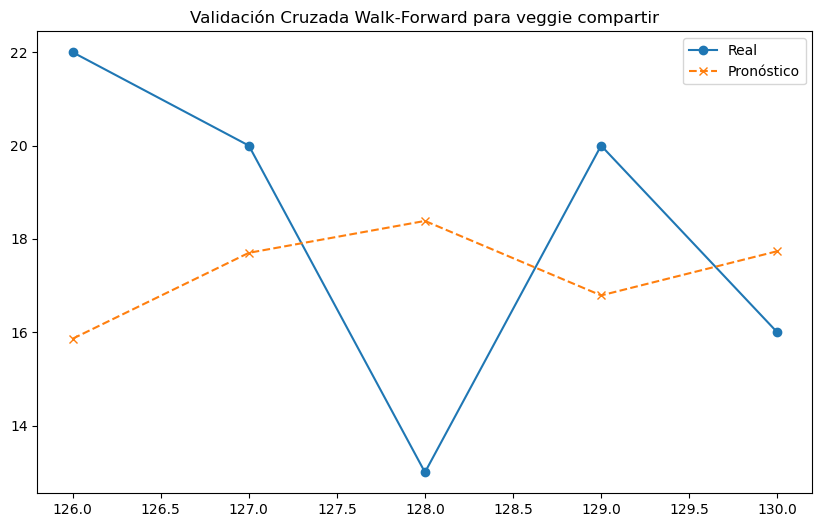

In [32]:
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = data[0:-n_test], data[-n_test:]
    history = [x for x in train]
    
    for i in range(len(test)):
        model = auto_arima(history, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_order=None, trace=False)
        yhat = model.predict(n_periods=1)[0]
        predictions.append(yhat)
        history.append(test[i])  # Agrega observaciones al entrenamiento para el próximo ciclo.
    
    error = np.sqrt(mean_squared_error(test, predictions))
    return error, test, predictions

resultados_rmse_wf= {}

# Ajuste de la cantidad de datos de prueba para la validación cruzada
n_test = 5  # Ejemplo: usar los últimos 5 puntos para la prueba

for producto in df_pivot.columns:
    serie_temporal = df_pivot[producto].dropna()
    
    # Aplicar validación cruzada "walk-forward"
    error, test, predictions = walk_forward_validation(serie_temporal, n_test)
    
    # Almacenar el error RMSE
    resultados_rmse_wf[producto] = error
    
    # Imprimir el RMSE para cada producto
    print(f"RMSE de validación cruzada para {producto}: {error:.3f}")
    
    # Opcional: graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(serie_temporal)-n_test, len(serie_temporal)), test, marker='o', label='Real')
    plt.plot(range(len(serie_temporal)-n_test, len(serie_temporal)), predictions, marker='x', linestyle='--', label='Pronóstico')
    plt.title(f'Validación Cruzada Walk-Forward para {producto}')
    plt.legend()
    plt.show()

In [33]:
df_rmse = pd.DataFrame(list(resultados_rmse.items()), columns=['Producto', 'RMSE Pre-Validación'])
df_rmse_wf = pd.DataFrame(list(resultados_rmse_wf.items()), columns=['Producto', 'RMSE Post-Validación'])
# Combinar ambos DataFrames
df_comparativo = pd.merge(df_rmse, df_rmse_wf, on='Producto')
df_comparativo

Producto  RMSE Pre-Validación  \
0                       2 SCHOP HEINEKEN            10.891622   
1   2 hamburguesas con papas + 2 bebidas             1.559413   
2            2 papas grandes + 2 bebidas             3.219364   
3                                Cheddar             3.954976   
4                                Chelada             6.734981   
5                          Chicken Box S             2.934716   
6                  Hamburguesa Americana             7.164845   
7                    Hamburguesa Clasica             8.686792   
8    Hamburguesa Clasica con papas promo             1.688580   
9                        Hamburguesa Hot             5.230339   
10               Hamburguesa Vegetariana             5.448876   
11                             Michelada             9.968025   
12                            Mistral 35            15.678400   
13                            Mistral 40            12.749219   
14                    Mojito tradicional             8.504720   
15                          Only Chicken             7.201939   
16                     Ramazzotti Spritz            10.645807   
17                          Sandi spritz            10.813883   
18                        Schop heineken            32.931725   
19                             Solsticio             3.996861   
20                      beefie compartir             7.251809   
21                     beefie individual             6.310947   
22            cheese and bacon compartir            15.438542   
23      cheese and bacon compartir promo             2.402984   
24           cheese and bacon individual             8.541390   
25            choclo champiñon compartir             4.314112   
26           choclo champiñon individual             4.828681   
27                             coca cola             7.952519   
28                       coca cola promo             4.125522   
29                  coca cola sin azucar             5.383424   
30            coca cola sin azucar promo             3.016898   
31                           fanta promo             2.647627   
32                     mechada compartir             5.532836   
33                    mechada individual             3.073280   
34                        mexa compartir             4.546833   
35              pollo albahaca compartir             3.338360   
36                single fries compartir             3.470538   
37                      veggie compartir             9.072241   

    RMSE Post-Validación  
0               8.593551  
1               0.760454  
2               3.364945  
3               4.904628  
4               8.262743  
5               0.526442  
6               3.832240  
7               7.566230  
8               1.277643  
9               3.310381  
10              2.892800  
11              7.029858  
12             12.859794  
13             13.196479  
14              8.412930  
15              5.417088  
16              6.718757  
17              4.725495  
18             12.518626  
19              5.070831  
20              7.160248  
21              4.805783  
22              8.601331  
23              2.780392  
24              2.667045  
25              6.136561  
26              3.443886  
27              4.509293  
28              1.693276  
29              3.558500  
30              0.783825  
31              4.662612  
32              3.986883  
33              2.226268  
34              1.472625  
35              2.366182  
36              3.442893  
37              4.129756

In [34]:
df_comparativo.to_csv('df_comparativo.csv', index=False)